In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import DBSCAN
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier
#from imblearn.over_sampling import SMOTE
#from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split

#from xgboost import XGBClassifier


# Frame the Problem and Look at the Big Picture

### Define the Objective in Business Terms
The objective is to develop a predictive model to identify fraudulent credit card transactions from a given dataset. This model aims to support financial institutions or payment processors in detecting and preventing fraud in real time, reducing financial losses and protecting customer accounts. The model should focus on prioritizing possible fraudulent transactions but still make sure that it is able to identify true fraudulent transactions as not to inconvenience customers.

### How Will Your Solution Be Used?
The solution will be implemented as part of the transaction processing system, providing real-time fraud classification. When a transaction is flagged as fraudulent, it will either be declined or sent for manual review by a fraud analyst. The client will use the model to improve their fraud detection efficiency, reduce reliance on manual reviews, and maintain customer trust by proactively addressing security concerns.

### What Are the Current Solutions/Workarounds (If Any)?
Currently, most fraud detection systems use rule-based engines that rely on predefined thresholds (e.g., large transactions or unusual locations). While effective to a degree, these systems often struggle with adapting to evolving fraud patterns and result in high false-positive rates. Manual reviews are used to address flagged transactions, which can be labor-intensive, slow, and costly.

### How Should You Frame This Problem?
This is a supervised binary classification problem where the goal is to classify each transaction as either "fraudulent" or "non-fraudulent" based on labeled historical data. The model will likely be deployed in an batch learning setting, because we could update the model in a certain timeframe as opposed to online learning where it is possible to use as well, but would need to be closely inspected as it could potentially inconvience customers where precision and/or recall could decrease. 

## How Should Performance Be Measured?
- **Metrics:**
  - Precision: To ensure flagged transactions are truly fraudulent, minimizing inconvenience to customers.
  - Recall (Prioritize): To catch as many fraudulent transactions as possible.
  - F1 Score: To balance precision and recall.
  - ROC-AUC: To evaluate overall classifier performance.

### Is the Performance Measure Aligned with the Business Objective?
Yes, the performance measures align with the business objective of reducing fraud while maintaining a positive customer experience. Emphasis should be placed on recall to ensure fraud is detected, but precision is also critical to prevent disruption for legitimate customers.

### What Would Be the Minimum Performance Needed to Reach the Business Objective?
The model must outperform the current rule-based system in terms of fraud detection rate while maintaining or improving the false-positive rate. For example, achieving at least 90% recall with a precision above 80% might be a realistic goal to satisfy business requirements.

### What Are Comparable Problems? Can You Reuse Experience or Tools?
- Comparable problems include the **Squirrel Prediction Model** and **Early Spring Prediction Model**, as they both involved working with a binary classification problem.
- Tools such as the **DBScan algorithm** used in the Squirrel model might be useful to find clusters as well as other clustering algorithms used in previous works such the notebook **Clustering**.

### Is Human Expertise Available?
Human expertise is available in the form of fraud analysts who currently review flagged transactions. Their domain knowledge can guide feature selection and model validation. Analysts can also provide labeled data to improve model performance and adapt it to emerging fraud trends.

### How Would You Solve the Problem Manually?
Manual fraud detection involves analyzing transaction patterns for anomalies such as:
- Unusual transaction locations or times.
- Large transaction amounts.
- Multiple small transactions in a short time span.  
Analysts would cross-reference transaction data with customer profiles and historical behaviors to assess risk. While effective for small datasets, this approach is impractical for high transaction volumes due to its inefficiency and susceptibility to human error.

### List the Assumptions You Have Made So Far (Verify if Possible)
The dataset is assumed to accurately represent real-world fraud patterns, containing sufficiently labeled examples of both fraudulent and non-fraudulent transactions. It is expected that fraudulent transactions make up only a small proportion compared to non-fraudulent ones. The features in the dataset, such as transaction amount, location, and time, are presumed to be predictive of fraud, with fraudulent transactions exhibiting distinguishable patterns from legitimate ones. Given the imbalance in the dataset, stratification will be necessary to ensure proper representation of both classes during training. This assumption is supported by the observation that fraudulent transactions are only a small fraction of the total samples.

In [3]:
# function to concat fraudTest.csv and fraudTrain.csv datasets

def concat_data():
    # read the datasets
    fraudTest = pd.read_csv('fraudTest.csv')
    fraudTrain = pd.read_csv('fraudTrain.csv')
    # concat the datasets
    data = pd.concat([fraudTrain, fraudTest], axis=0)
    return data



In [4]:
data = concat_data()

In [5]:
#search for NAN values

data.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   trans_date_trans_time  object 
 2   cc_num                 int64  
 3   merchant               object 
 4   category               object 
 5   amt                    float64
 6   first                  object 
 7   last                   object 
 8   gender                 object 
 9   street                 object 
 10  city                   object 
 11  state                  object 
 12  zip                    int64  
 13  lat                    float64
 14  long                   float64
 15  city_pop               int64  
 16  job                    object 
 17  dob                    object 
 18  trans_num              object 
 19  unix_time              int64  
 20  merch_lat              float64
 21  merch_long             float64
 22  is_fraud               i

In [7]:
data.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06
mean,5.371934e+05,4.173860e+17,7.006357e+01,4.881326e+04,3.853931e+01,-9.022783e+01,8.864367e+04,1.358674e+09,3.853898e+01,-9.022794e+01,5.210015e-03
std,3.669110e+05,1.309115e+18,1.592540e+02,2.688185e+04,5.071470e+00,1.374789e+01,3.014876e+05,1.819508e+07,5.105604e+00,1.375969e+01,7.199217e-02
min,0.000000e+00,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902742e+01,-1.666716e+02,0.000000e+00
25%,2.315490e+05,1.800429e+14,9.640000e+00,2.623700e+04,3.466890e+01,-9.679800e+01,7.410000e+02,1.343017e+09,3.474012e+01,-9.689944e+01,0.000000e+00
50%,4.630980e+05,3.521417e+15,4.745000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.443000e+03,1.357089e+09,3.936890e+01,-8.744069e+01,0.000000e+00
75%,8.335758e+05,4.642255e+15,8.310000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.374581e+09,4.195626e+01,-8.024511e+01,0.000000e+00
max,1.296674e+06,4.992346e+18,2.894890e+04,9.992100e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.388534e+09,6.751027e+01,-6.695090e+01,1.000000e+00


In [8]:
data["is_fraud"].value_counts()

is_fraud
0    1842743
1       9651
Name: count, dtype: int64

The original dataset gave us a train and test set obviously consisting of the same variables. We decided to recombine them and split them ourselves just to make sure the splitting was random.

No NA values in the data. This is a very clean dataset and makes the cleaning the data section way easier.

23 features. A decent amount. Just looking at the feature names I want to look deeper into what merchant, amt, Unnamed, trans_num, and unix_time are.

11 of our features are numbers, only a few of them should actually be treated like that though (ie. lat and long should not be scaled or anything).

Target label is is_fraud. There are obviously a lot more cases of not being fraud over fraud.  This is the only feature we will stratify on as it is a classification problem and the target label has to be stratified ALWAYS.

We definitely have to lower the amount of samples. More data is always good, however to much data causes us serious memory issues and we will not be able to run all of it. we will randomly take 100000 samples because we feel that is a large enough dataset to find patterns on.

In [9]:
# randomly take 100000 samples from the dataset

data = data.sample(n=100000, random_state=42)


In [10]:
data["is_fraud"].value_counts()

is_fraud
0    99457
1      543
Name: count, dtype: int64

In [11]:
# stratify on is_fraud to have the same proportion of fraud in train and test set take 20% of the data for the test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=["is_fraud"]), data["is_fraud"], test_size=0.2, stratify=data["is_fraud"], random_state=42)

In [12]:
# train set

train = X_train.copy()
train['is_fraud'] = y_train

array([[<Axes: title={'center': 'Unnamed: 0'}>,
        <Axes: title={'center': 'cc_num'}>,
        <Axes: title={'center': 'amt'}>],
       [<Axes: title={'center': 'zip'}>, <Axes: title={'center': 'lat'}>,
        <Axes: title={'center': 'long'}>],
       [<Axes: title={'center': 'city_pop'}>,
        <Axes: title={'center': 'unix_time'}>,
        <Axes: title={'center': 'merch_lat'}>],
       [<Axes: title={'center': 'merch_long'}>,
        <Axes: title={'center': 'is_fraud'}>, <Axes: >]], dtype=object)

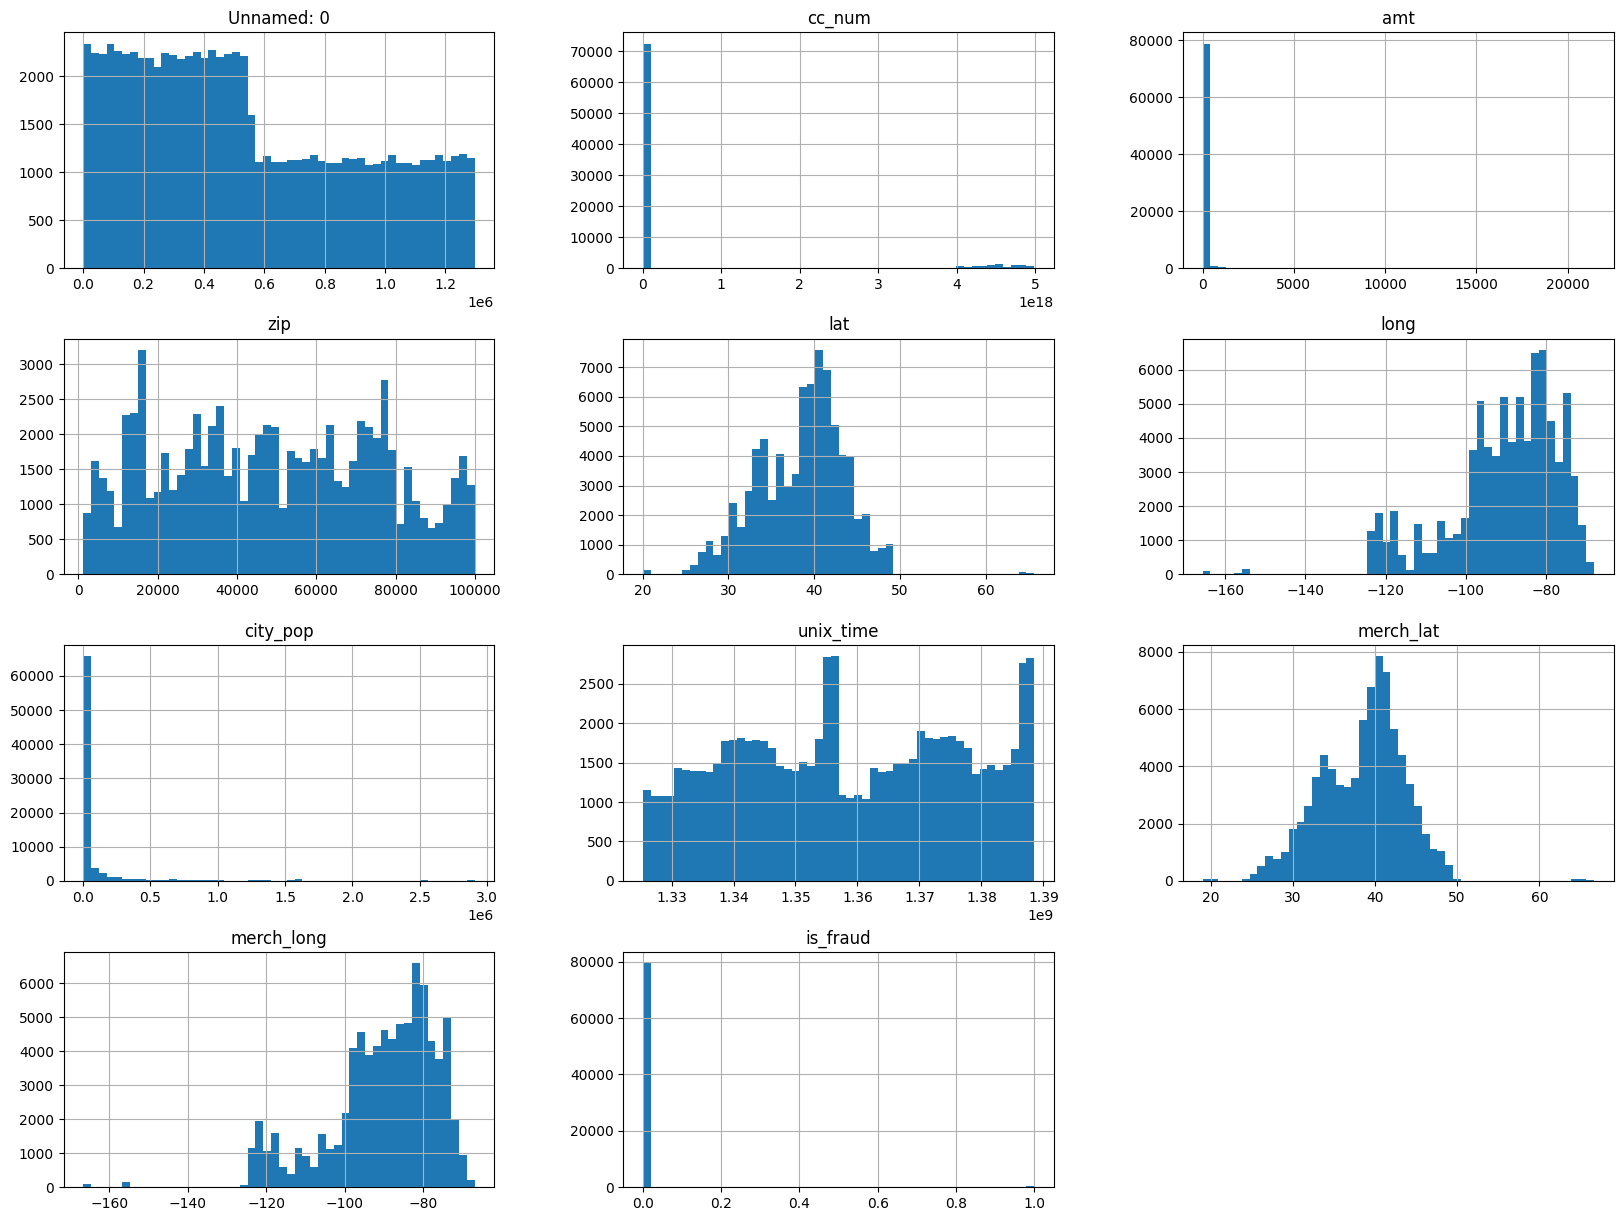

In [13]:
#histogram of train set

train.hist(bins=50, figsize=(20,15))

# Data Exploration

In [14]:
pd.set_option('display.max_columns', None)
train.head()


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
769453,769453,2019-11-25 10:23:37,343668971234893,fraud_Friesen-D'Amore,gas_transport,78.16,Sally,Moore,F,835 Reese Views Suite 884,Hopkins,SC,29061,33.9349,-80.8449,13717,Chiropodist,1949-11-16,d31441e7924a9d4ced7e704e1a73f0e4,1353839017,33.990387,-80.951300,0
1122154,1122154,2020-04-12 15:17:46,580954173374,fraud_Reilly LLC,home,46.18,Jessica,Benitez,F,31281 Thomas Inlet,Montrose,NY,10548,41.2496,-73.9446,3487,Race relations officer,1960-01-13,57d1e1ea208cd3688044bc7063d10d02,1365779866,41.032949,-74.367322,0
365544,365544,2019-06-18 13:02:41,372520049757633,fraud_Pouros-Conroy,shopping_pos,145.98,Lori,Ramirez,F,4293 Ramirez Squares,Ranier,MN,56668,48.6031,-93.2977,136,Ceramics designer,2000-02-20,78b154f21c1299ae8fb6670207090009,1340024561,49.177089,-92.364430,0
553959,553959,2020-12-31 13:49:41,3590736522064285,"fraud_Nitzsche, Kessler and Wolff",shopping_pos,26.45,Kimberly,Gonzalez,F,72966 Shannon Pass Apt. 391,Bauxite,AR,72011,34.5091,-92.4828,4074,"Scientist, audiological",1975-12-20,e74cd23de7b688787c2bdbb59cecadf5,1388497781,34.357879,-91.983420,0
1010939,1010939,2020-02-20 17:33:28,4294040533480516,"fraud_Bins, Balistreri and Beatty",shopping_pos,1.57,Gail,Weaver,F,979 Stewart Lake,New Ellenton,SC,29809,33.4130,-81.6900,2206,Biomedical scientist,1986-12-31,806434cf934f0ea42557aa8f177ecab6,1361381608,34.400207,-82.529902,0


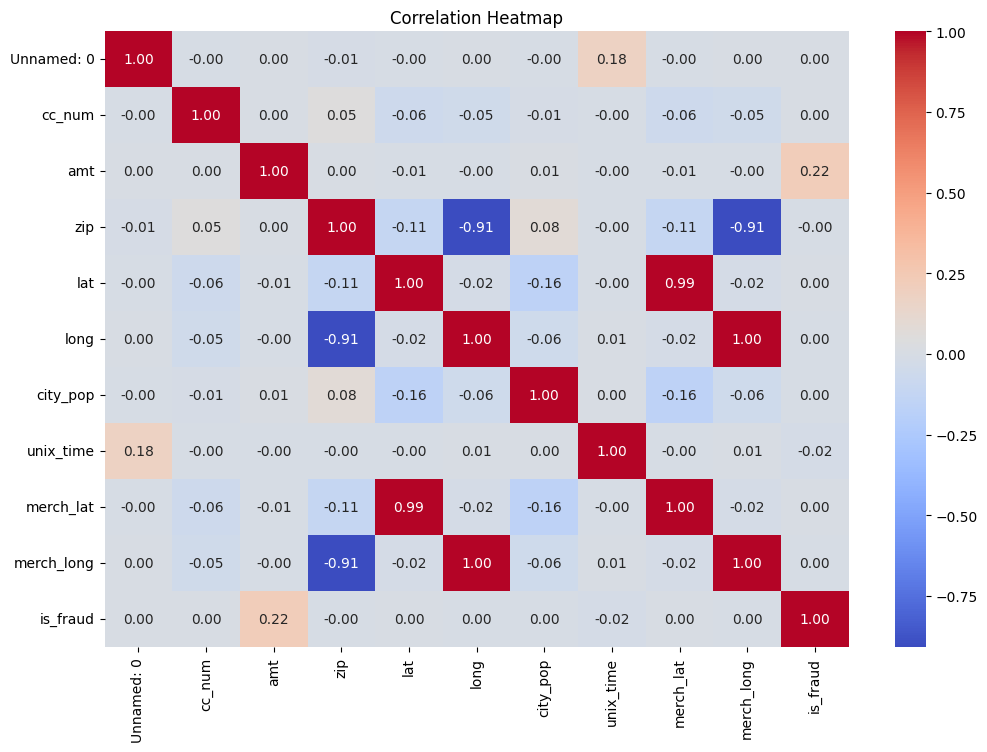

In [15]:
# Select only numerical columns
numerical_cols = train.select_dtypes(include=['float64', 'int64'])

# Calculate correlation matrix
correlation_matrix = numerical_cols.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

From this correlation heatmap alone, there is a fair correlation with the `amt` feature. Might want to explore further to see any more correlations from within. 

           log_amt  is_fraud
log_amt   1.000000  0.123741
is_fraud  0.123741  1.000000


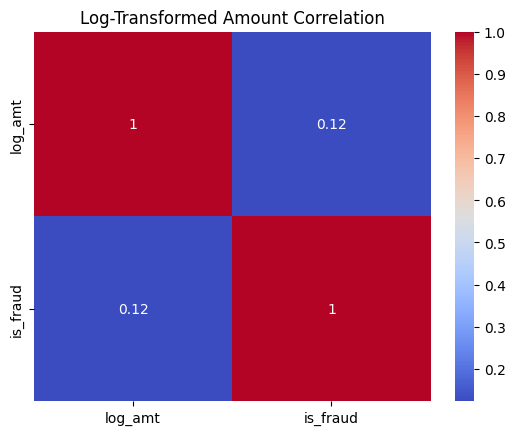

In [16]:
train['log_amt'] = train['amt'].apply(lambda x: np.log1p(x))

# Plot correlation after transformation
correlation_matrix = train[['log_amt', 'is_fraud']].corr()
print(correlation_matrix)

# Heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Log-Transformed Amount Correlation")
plt.show()

amt_bin
Very Low     0.001951
Low          0.000125
Medium       0.009493
High         0.217143
Very High    0.271318
Name: is_fraud, dtype: float64


/var/folders/bp/tqx1fv0145x29m0h097lbn2r0000gp/T/ipykernel_10541/2101281669.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate_by_bin = train.groupby('amt_bin')['is_fraud'].mean()


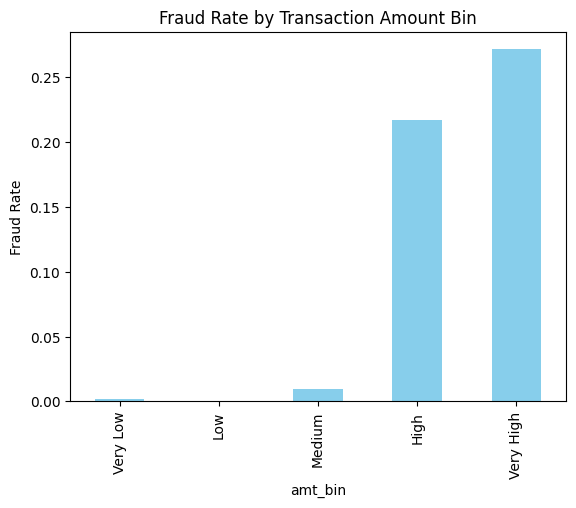

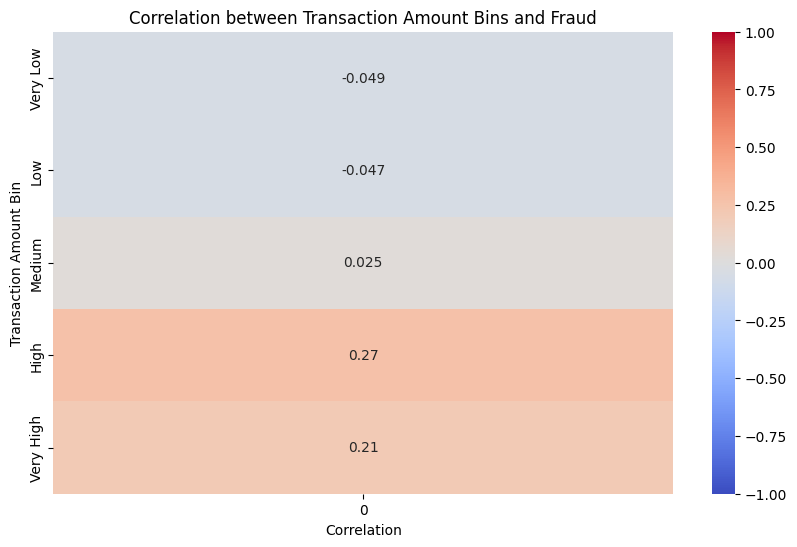

In [17]:
train['amt_bin'] = pd.cut(train['amt'], bins=[0, 50, 100, 500, 1000, float('inf')], labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# Fraud rate by bin
fraud_rate_by_bin = train.groupby('amt_bin')['is_fraud'].mean()
print(fraud_rate_by_bin)

# Bar plot
fraud_rate_by_bin.plot(kind='bar', color='skyblue')
plt.title("Fraud Rate by Transaction Amount Bin")
plt.ylabel("Fraud Rate")
plt.show()
# Calculate correlation between amt_bin and is_fraud
amt_bin_corr = pd.get_dummies(train['amt_bin']).corrwith(train['is_fraud'])

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(amt_bin_corr.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation between Transaction Amount Bins and Fraud")
plt.xlabel("Correlation")
plt.ylabel("Transaction Amount Bin")
plt.show()

In [18]:
# create new feature for if the amount spent was in the top 90% of its respective "category" feature

train['amt_top90'] = train['amt'] > train.groupby('category')['amt'].transform(lambda x: x.quantile(0.90))

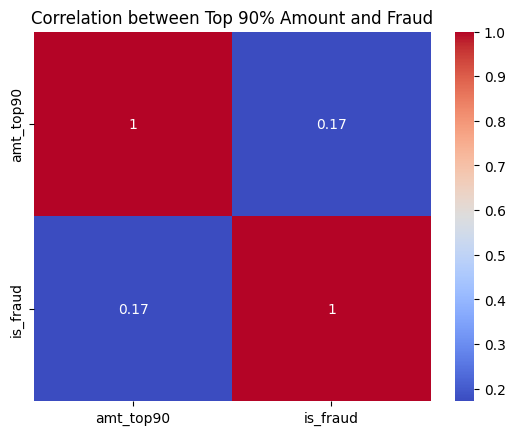

In [19]:
# heatmap of correlation between amt_top90 and is_fraud

correlation_matrix = train[['amt_top90', 'is_fraud']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation between Top 90% Amount and Fraud")
plt.show()



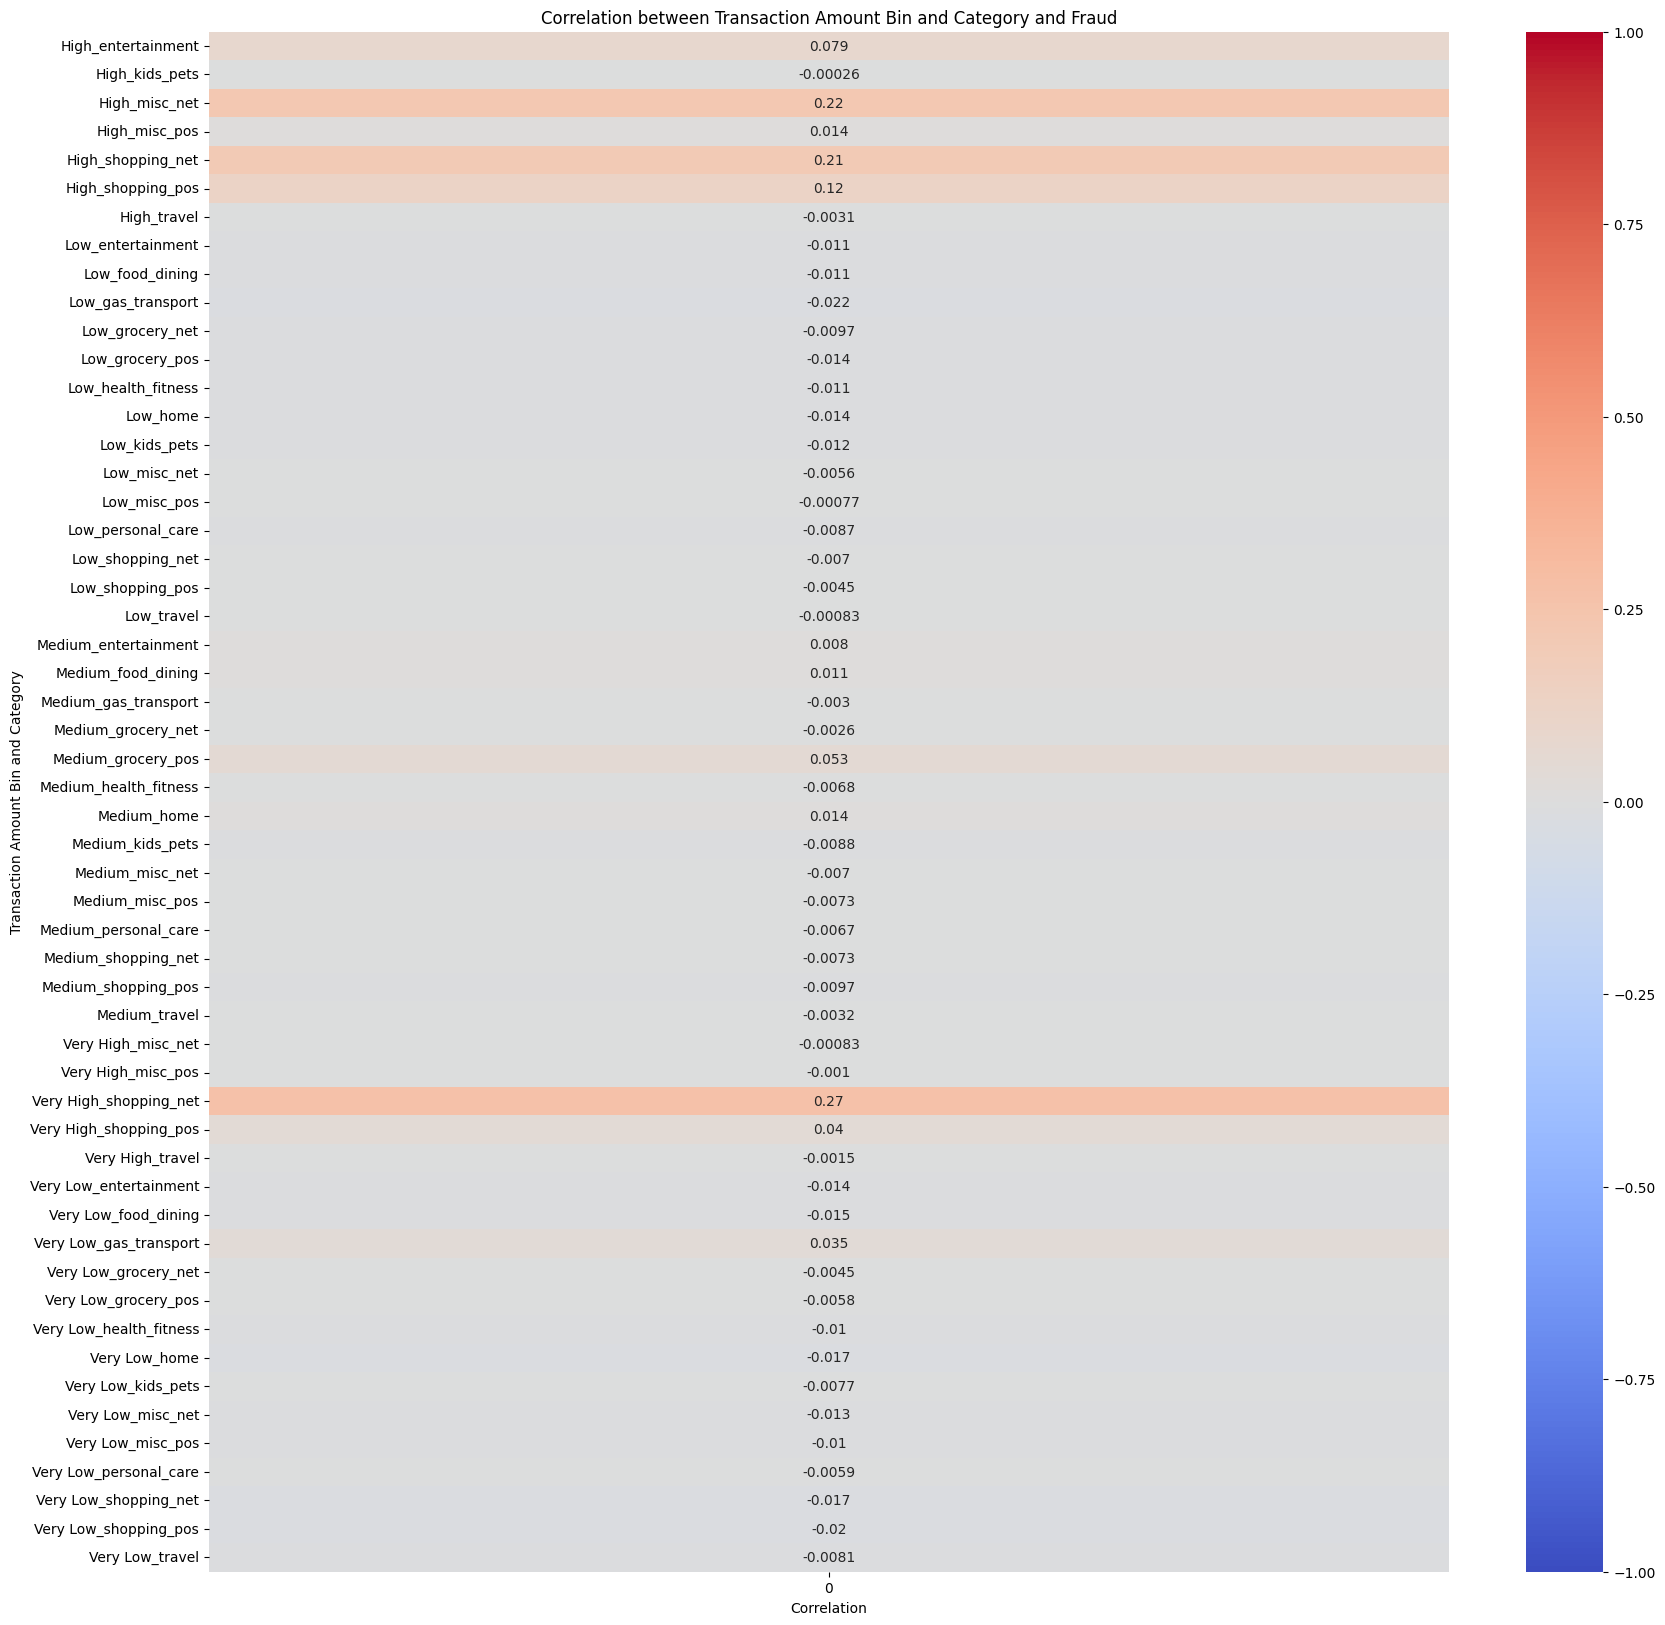

In [20]:
# Create a new feature combining amt_bin and category
train['amt_bin_category'] = train['amt_bin'].astype(str) + '_' + train['category']

# Calculate correlation between amt_bin_category and is_fraud
amt_bin_category_corr = pd.get_dummies(train['amt_bin_category']).corrwith(train['is_fraud'])

# Plot the heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(amt_bin_category_corr.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation between Transaction Amount Bin and Category and Fraud")
plt.xlabel("Correlation")
plt.ylabel("Transaction Amount Bin and Category")
plt.show()

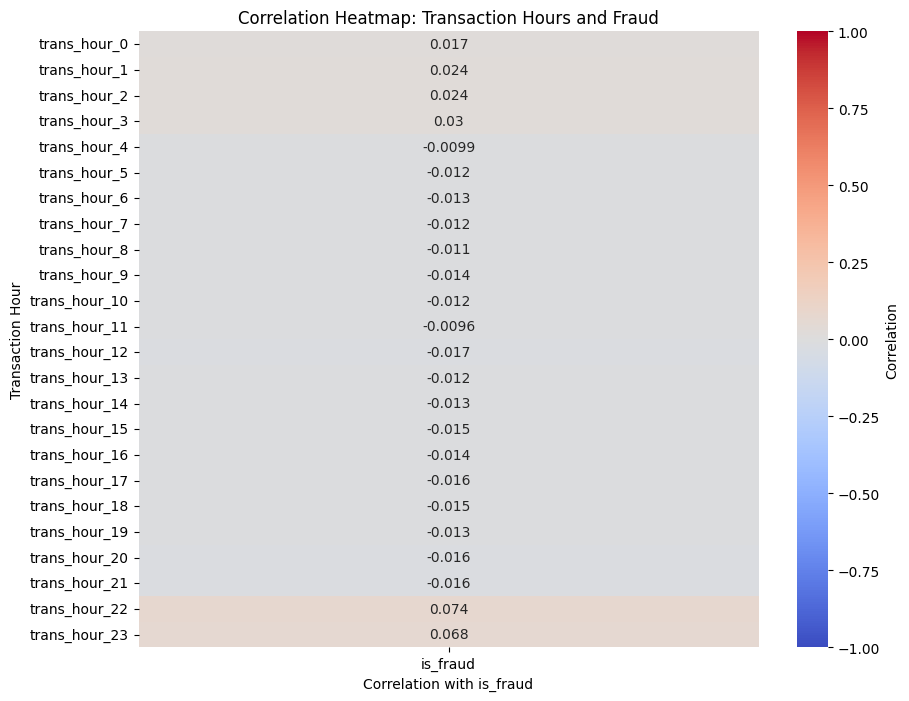

In [21]:
# Convert 'trans_date_trans_time' to datetime format
train['trans_date_trans_time'] = pd.to_datetime(train['trans_date_trans_time'])

# Extract hour of the transaction
train['trans_hour'] = train['trans_date_trans_time'].dt.hour

# Create binary columns for each hour (trans_hour_0, trans_hour_1, ..., trans_hour_23)
for hour in range(24):
    train[f'trans_hour_{hour}'] = (train['trans_hour'] == hour).astype(int)

# Calculate correlations with 'is_fraud'
hour_columns = [f'trans_hour_{hour}' for hour in range(24)]
correlation_matrix = train[hour_columns + ['is_fraud']].corr()

# Extract only the correlations of trans_hour features with 'is_fraud'
correlation_with_fraud = correlation_matrix.loc[hour_columns, 'is_fraud']

# Plot heatmap of the correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_with_fraud.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
plt.title('Correlation Heatmap: Transaction Hours and Fraud')
plt.yticks(rotation=0)
plt.xlabel('Correlation with is_fraud')
plt.ylabel('Transaction Hour')
plt.show()

In [22]:
date_range = data['trans_date_trans_time'].agg(['min', 'max'])
print(date_range)

min    2019-01-01 00:18:06
max    2020-12-31 23:57:50
Name: trans_date_trans_time, dtype: object


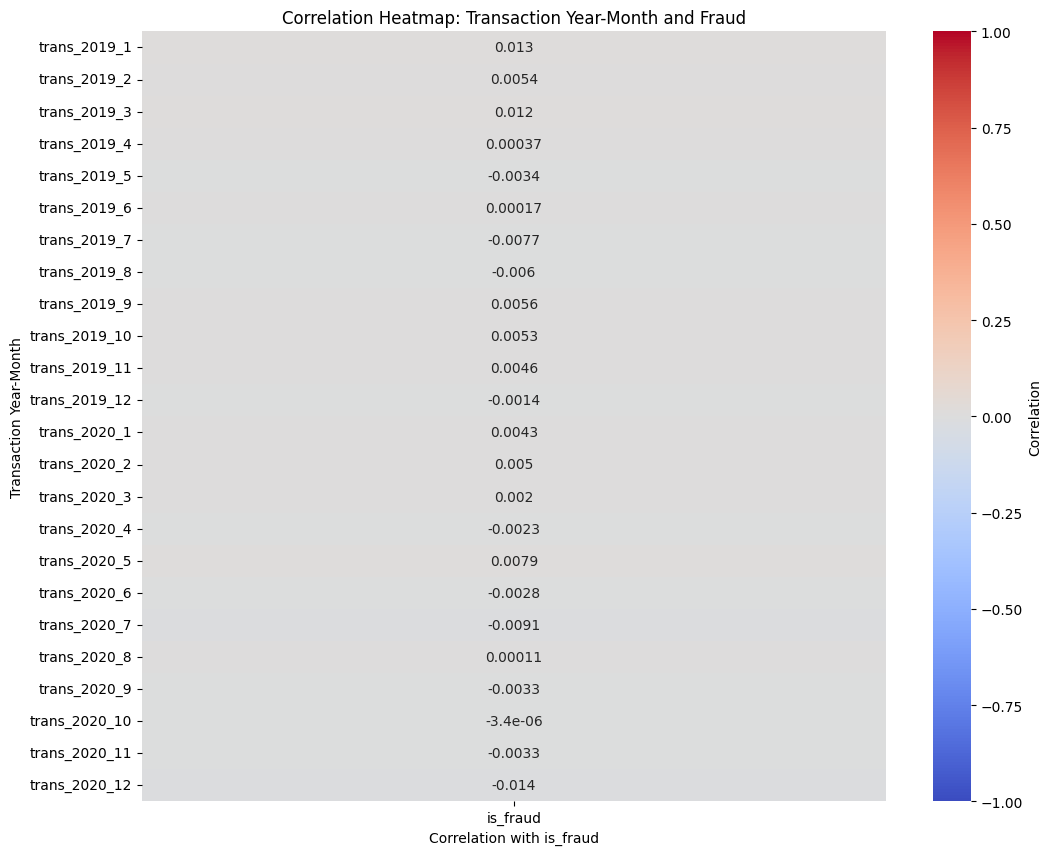

In [23]:
# Extract year and month from 'trans_date_trans_time'
train['trans_year'] = train['trans_date_trans_time'].dt.year
train['trans_month'] = train['trans_date_trans_time'].dt.month

# Create binary columns for each combination of year and month (e.g., trans_2019_1, trans_2019_2, ..., trans_2020_12)
for year in train['trans_year'].unique():
    for month in range(1, 13):
        train[f'trans_{year}_{month}'] = ((train['trans_year'] == year) & (train['trans_month'] == month)).astype(int)

# Calculate correlations with 'is_fraud'
year_month_columns = [f'trans_{year}_{month}' for year in train['trans_year'].unique() for month in range(1, 13)]
correlation_matrix = train[year_month_columns + ['is_fraud']].corr()

# Extract only the correlations of year_month features with 'is_fraud'
correlation_with_fraud = correlation_matrix.loc[year_month_columns, 'is_fraud']

# Plot heatmap of the correlations
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_with_fraud.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
plt.title('Correlation Heatmap: Transaction Year-Month and Fraud')
plt.yticks(rotation=0)
plt.xlabel('Correlation with is_fraud')
plt.ylabel('Transaction Year-Month')
plt.show()

is_fraud         1
gender            
F         0.005261
M         0.005623


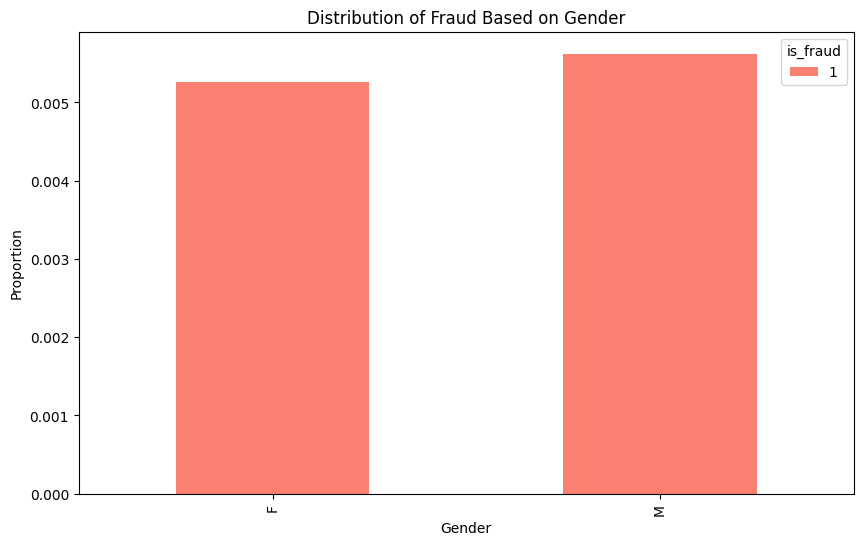

In [24]:
# Create a table to see the distribution of is_fraud based on gender
fraud_gender_table = pd.crosstab(train['gender'], train['is_fraud'], normalize='index')

# Display only the fraud column
fraud_only_table = fraud_gender_table[[1]]

# Display the table
print(fraud_only_table)

# Plot the bar graph
fraud_only_table.plot(kind='bar', figsize=(10, 6), color='salmon')
plt.title('Distribution of Fraud Based on Gender')
plt.xlabel('Gender')
plt.ylabel('Proportion')
plt.show()

It is shown that males have a higher count of fraudulent transactions compared to females.

## Correlation with times and days
Will begin to look into the times and days and see if there is any correlation that can be used with a combination of other features that could give us more insight on what could give us more correlation to out target label. 

In [25]:
# Convert 'trans_date_trans_time' to datetime format if not already done
train['trans_date_trans_time'] = pd.to_datetime(train['trans_date_trans_time'])

# Extract week, month, day, hour, minute, and second
train['trans_week'] = train['trans_date_trans_time'].dt.isocalendar().week
train['trans_month'] = train['trans_date_trans_time'].dt.month
train['trans_day'] = train['trans_date_trans_time'].dt.day
train['trans_hour'] = train['trans_date_trans_time'].dt.hour
train['trans_minute'] = train['trans_date_trans_time'].dt.minute
train['trans_second'] = train['trans_date_trans_time'].dt.second

# Display the first few rows to verify the new features
train[['trans_date_trans_time', 'trans_week', 'trans_month', 'trans_day', 'trans_hour', 'trans_minute', 'trans_second']].head()

,trans_date_trans_time,trans_week,trans_month,trans_day,trans_hour,trans_minute,trans_second
769453,2019-11-25 10:23:37,48,11,25,10,23,37
1122154,2020-04-12 15:17:46,15,4,12,15,17,46
365544,2019-06-18 13:02:41,25,6,18,13,2,41
553959,2020-12-31 13:49:41,53,12,31,13,49,41
1010939,2020-02-20 17:33:28,8,2,20,17,33,28


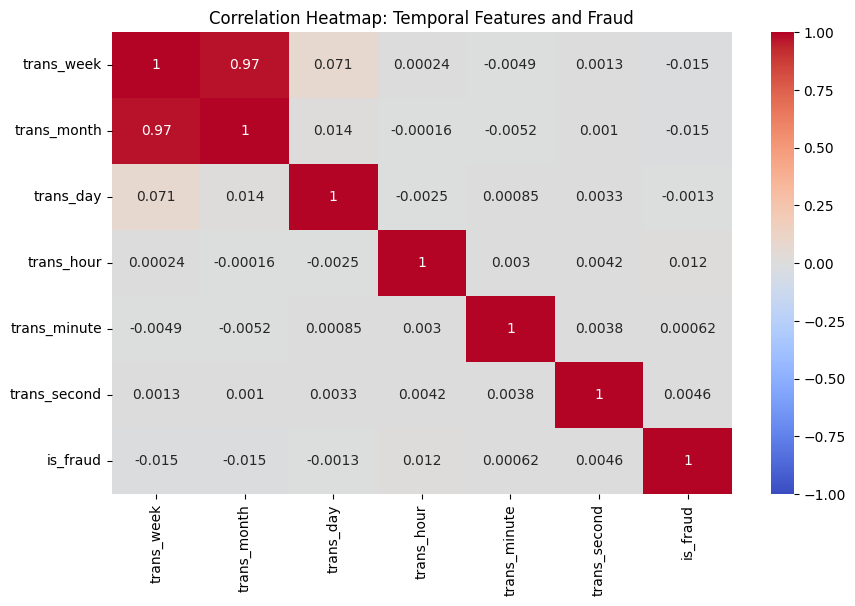

In [26]:
# Select temporal features and the target variable
temporal_features = ['trans_week', 'trans_month', 'trans_day', 'trans_hour', 'trans_minute', 'trans_second', 'is_fraud']

# Compute correlations
correlation_matrix = train[temporal_features].corr()

# Plot correlation heatmap
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap: Temporal Features and Fraud')
plt.show()


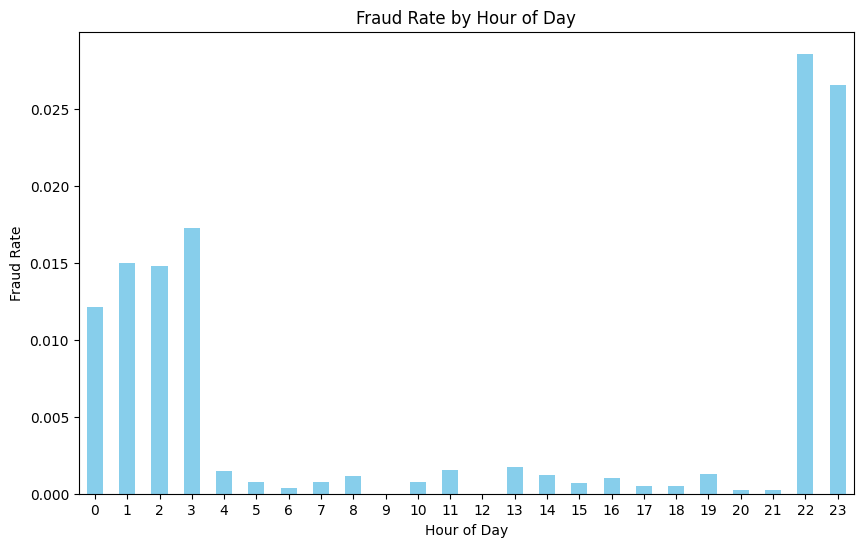

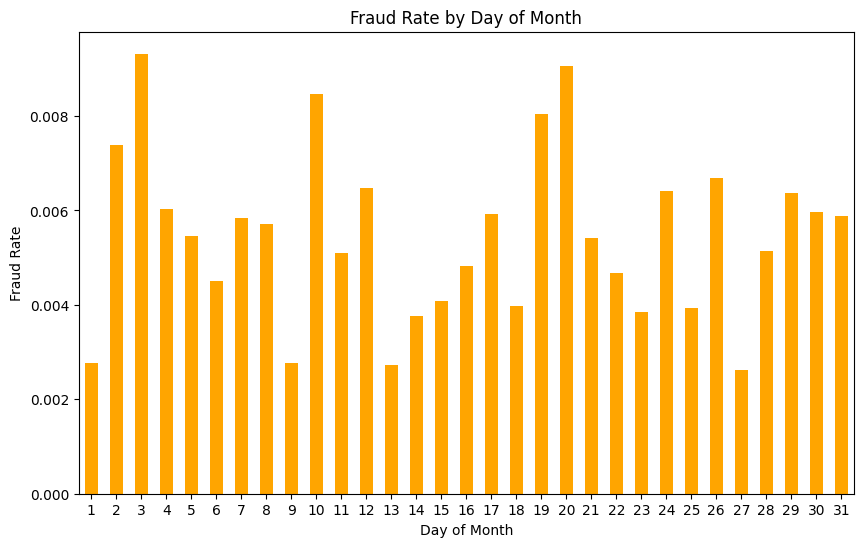

In [27]:
# Fraud rate by hour
fraud_by_hour = train.groupby('trans_hour')['is_fraud'].mean()
fraud_by_hour.plot(kind='bar', color='skyblue', figsize=(10, 6))
plt.title('Fraud Rate by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=0)
plt.show()

# Fraud rate by day
fraud_by_day = train.groupby('trans_day')['is_fraud'].mean()
fraud_by_day.plot(kind='bar', color='orange', figsize=(10, 6))
plt.title('Fraud Rate by Day of Month')
plt.xlabel('Day of Month')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=0)
plt.show()


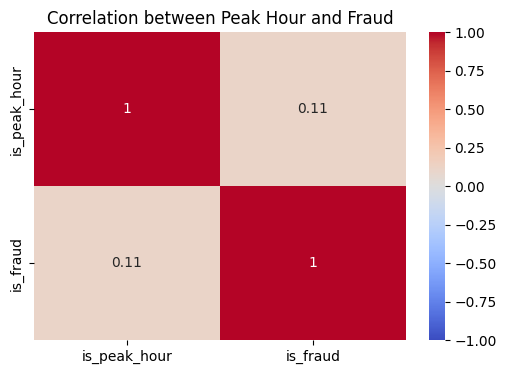

In [28]:
# Create a binary feature for transactions between 10 PM and 3 AM
train['is_peak_hour'] = train['trans_hour'].apply(lambda x: 1 if x >= 22 or x <= 3 else 0)

# Calculate the correlation between the new feature and the target label
peak_hour_corr = train[['is_peak_hour', 'is_fraud']].corr()

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(peak_hour_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Peak Hour and Fraud')
plt.show()

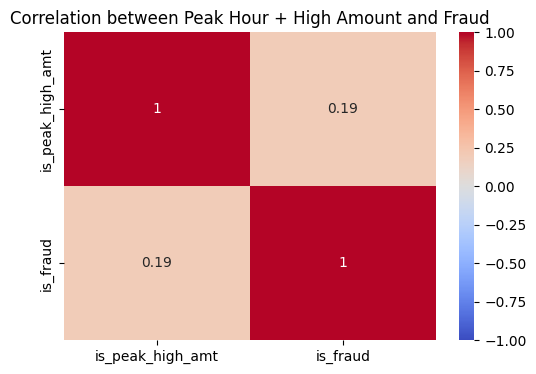

In [29]:
# Define a threshold for high transaction amounts (e.g., 75th percentile)
amt_threshold = train['amt'].quantile(0.75)

# Create combined feature
train['is_peak_high_amt'] = ((train['is_peak_hour'] == 1) & (train['amt'] > amt_threshold)).astype(int)

# Calculate correlation
combined_corr = train[['is_peak_high_amt', 'is_fraud']].corr()

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(combined_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Peak Hour + High Amount and Fraud')
plt.show()


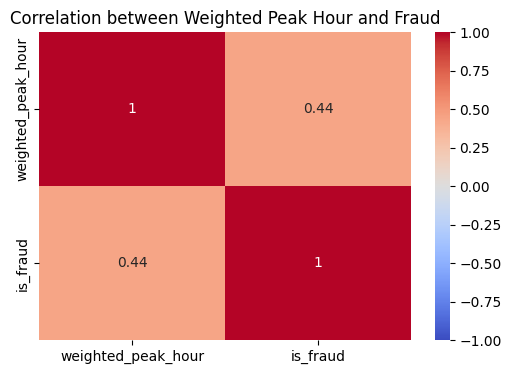

In [30]:
# Weighted peak hour feature
train['weighted_peak_hour'] = train['is_peak_hour'] * train['amt']

# Calculate correlation
weighted_corr = train[['weighted_peak_hour', 'is_fraud']].corr()

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(weighted_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Weighted Peak Hour and Fraud')
plt.show()


day_of_week
0    0.003982
1    0.004476
2    0.005229
3    0.007311
4    0.007033
5    0.006197
6    0.005088
Name: is_fraud, dtype: float64


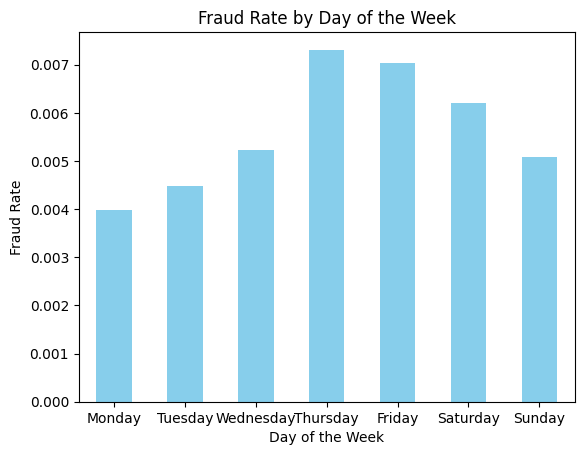

season
Fall      0.005980
Spring    0.006453
Summer    0.004032
Winter    0.005567
Name: is_fraud, dtype: float64


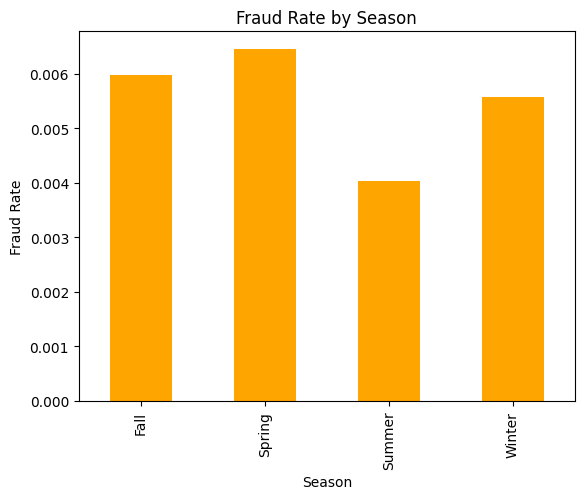

In [31]:
# Convert 'trans_date_trans_time' to datetime format if not already done
train['trans_date_trans_time'] = pd.to_datetime(train['trans_date_trans_time'])

# Extract day of the week and season from 'trans_date_trans_time'
train['day_of_week'] = train['trans_date_trans_time'].dt.dayofweek
train['season'] = train['trans_date_trans_time'].dt.month % 12 // 3 + 1

# Map season numbers to season names
season_mapping = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
train['season'] = train['season'].map(season_mapping)

# Calculate fraud rate by day of the week
fraud_rate_by_day_of_week = train.groupby('day_of_week')['is_fraud'].mean()
print(fraud_rate_by_day_of_week)

# Plot the fraud rate by day of the week
fraud_rate_by_day_of_week.plot(kind='bar', color='skyblue')
plt.title("Fraud Rate by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Fraud Rate")
plt.xticks(ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=0)
plt.show()

# Calculate fraud rate by season
fraud_rate_by_season = train.groupby('season')['is_fraud'].mean()
print(fraud_rate_by_season)

# Plot the fraud rate by season
fraud_rate_by_season.plot(kind='bar', color='orange')
plt.title("Fraud Rate by Season")
plt.xlabel("Season")
plt.ylabel("Fraud Rate")
plt.show()

In [32]:
# Create weekend feature
train['is_weekend'] = train['trans_week'].apply(lambda x: 1 if x in [6, 7] else 0)

# Create night transaction feature
train['is_night'] = train['trans_hour'].apply(lambda x: 1 if x >= 23 or x <= 4 else 0)

# Check fraud rate for new features
weekend_fraud_rate = train.groupby('is_weekend')['is_fraud'].mean()
print("Weekend Fraud Rate:\n", weekend_fraud_rate)

night_fraud_rate = train.groupby('is_night')['is_fraud'].mean()
print("Night Fraud Rate:\n", night_fraud_rate)


Weekend Fraud Rate:
 is_weekend
0    0.005363
1    0.007797
Name: is_fraud, dtype: float64
Night Fraud Rate:
 is_night
0    0.002602
1    0.015624
Name: is_fraud, dtype: float64


## Gender Correlation

gender
F    0.005261
M    0.005623
Name: is_fraud, dtype: float64


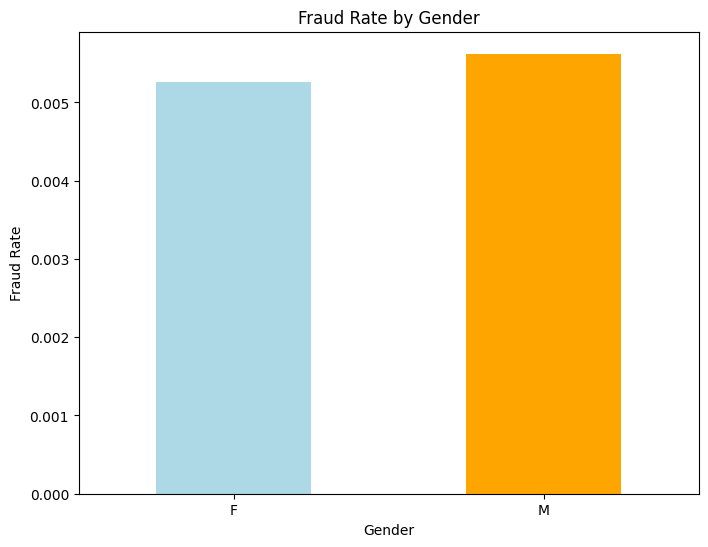

In [33]:
# Calculate fraud rates by gender
fraud_by_gender = train.groupby('gender')['is_fraud'].mean()
print(fraud_by_gender)

# Visualize fraud rates
fraud_by_gender.plot(kind='bar', color=['lightblue', 'orange'], figsize=(8, 6))
plt.title('Fraud Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=0)
plt.show()


/var/folders/bp/tqx1fv0145x29m0h097lbn2r0000gp/T/ipykernel_10541/2794293322.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_gender_amt = train.groupby(['gender', 'amt_category'])['is_fraud'].mean().unstack()


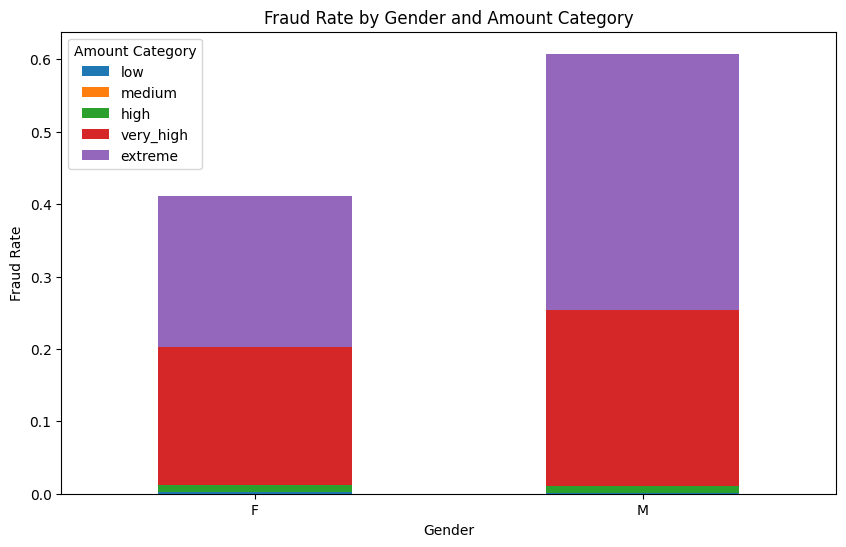

In [34]:
# Fraud rate by gender and amount category
train['amt_category'] = pd.cut(train['amt'], bins=[0, 50, 100, 500, 1000, float('inf')], labels=['low', 'medium', 'high', 'very_high', 'extreme'])
fraud_gender_amt = train.groupby(['gender', 'amt_category'])['is_fraud'].mean().unstack()

# Visualize
fraud_gender_amt.plot(kind='bar', figsize=(10, 6), stacked=True)
plt.title('Fraud Rate by Gender and Amount Category')
plt.xlabel('Gender')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=0)
plt.legend(title='Amount Category')
plt.show()


In [35]:
# Flag for males with high transaction amounts
train['is_high_amt_male'] = ((train['gender'] == 'M') & (train['amt'] > 1000)).astype(int)

In [36]:
# Combine gender and peak hours
train['male_peak_hour'] = ((train['gender'] == 'M') & (train['is_peak_hour'] == 1)).astype(int)

In [37]:
# Weighted gender feature
train['weighted_gender_amt'] = train['gender'].apply(lambda x: 1 if x == 'M' else 0) * train['amt']

In [38]:
# Flag for women with high transaction amounts
train['is_high_amt_female'] = ((train['gender'] == 'F') & (train['amt'] > 1000)).astype(int)

In [39]:
# Combine gender and peak hours
train['female_peak_hour'] = ((train['gender'] == 'F') & (train['is_peak_hour'] == 1)).astype(int)

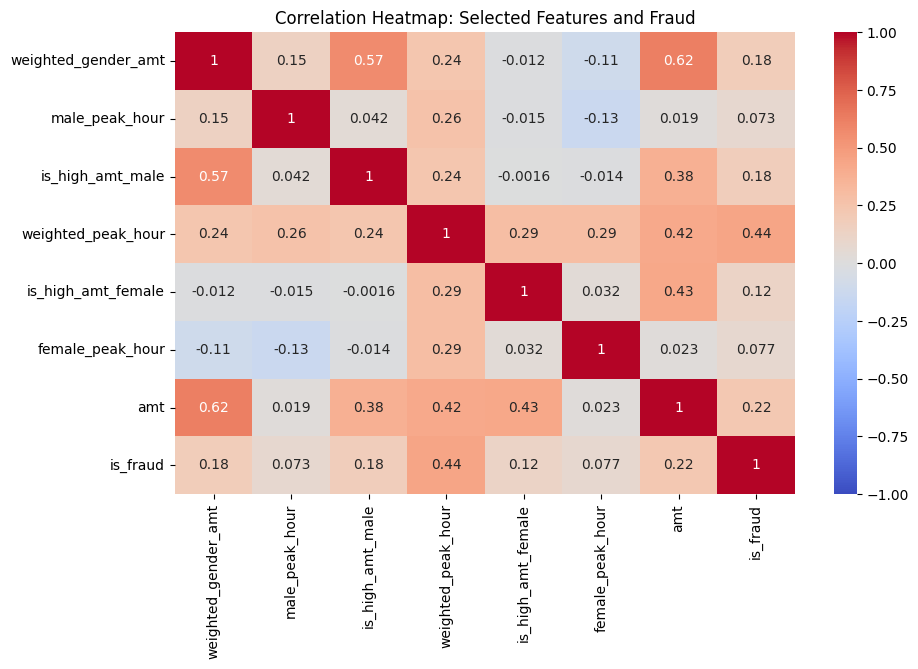

In [40]:
# Select the relevant columns
correlation_features = ['weighted_gender_amt', 'male_peak_hour', 'is_high_amt_male', 'weighted_peak_hour', 'is_high_amt_female', 'female_peak_hour', 'amt', 'is_fraud']

# Calculate the correlation matrix
correlation_matrix = train[correlation_features].corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap: Selected Features and Fraud')
plt.show()

- Gender seems to be important when paired with other variables. For example, pairing 

In [41]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# Select relevant features for clustering
features = train[['lat', 'long', 'amt', 'is_peak_hour']]

# Scale the features to standardize units
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=10)  # Adjust eps and min_samples as needed
train['geo_cluster'] = dbscan.fit_predict(features_scaled)

# Count clusters
print(train['geo_cluster'].value_counts())


geo_cluster
 0     60684
 1     18404
-1       532
 2       108
 5        71
 4        63
 3        48
 7        31
 6        24
 8        16
 10       10
 9         9
Name: count, dtype: int64


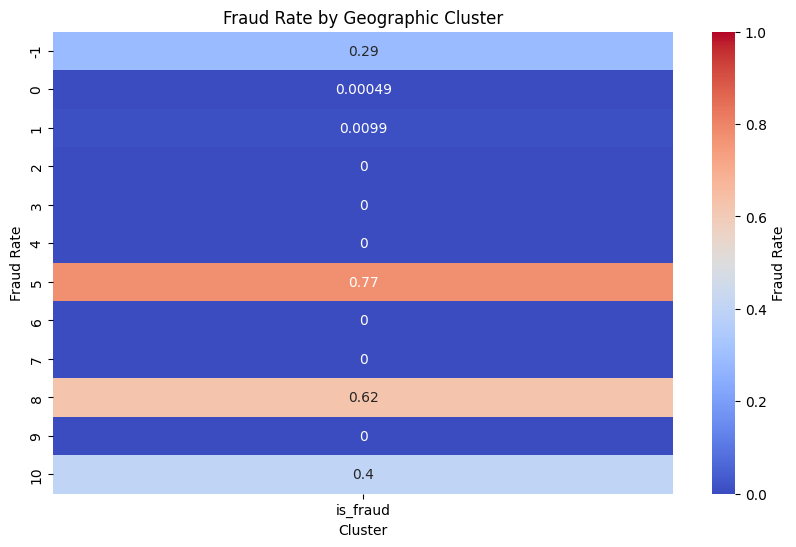

In [42]:
# compare geo_cluster with is_fraud with heatmap

# Calculate fraud rate by cluster
fraud_by_cluster = train.groupby('geo_cluster')['is_fraud'].mean()

# Visualize fraud rates by cluster
plt.figure(figsize=(10, 6))

# Plot the heatmap

sns.heatmap(fraud_by_cluster.to_frame(), annot=True, cmap='coolwarm', vmin=0, vmax=1, cbar_kws={'label': 'Fraud Rate'})
plt.title('Fraud Rate by Geographic Cluster')
plt.xlabel('Cluster')
plt.ylabel('Fraud Rate')
plt.show()


In [43]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# # Select temporal features for clustering
temporal_features = train[['trans_hour', 'trans_minute', 'trans_second']]
scaler = StandardScaler()
temporal_scaled = scaler.fit_transform(temporal_features)

# # Apply DBSCAN
dbscan = DBSCAN(eps=0.13, min_samples=15)
train['temporal_cluster'] = dbscan.fit_predict(temporal_scaled)

# # Analyze fraud rate by temporal cluster
temporal_fraud_rate = train.groupby('temporal_cluster')['is_fraud'].mean()
print("Fraud Rate by Temporal Cluster:\n", temporal_fraud_rate)


Fraud Rate by Temporal Cluster:
 temporal_cluster
-1     0.004394
 0     0.000650
 1     0.000725
 2     0.001734
 3     0.000489
         ...   
 95    0.090909
 96    0.000000
 97    0.000000
 98    0.062500
 99    0.000000
Name: is_fraud, Length: 101, dtype: float64


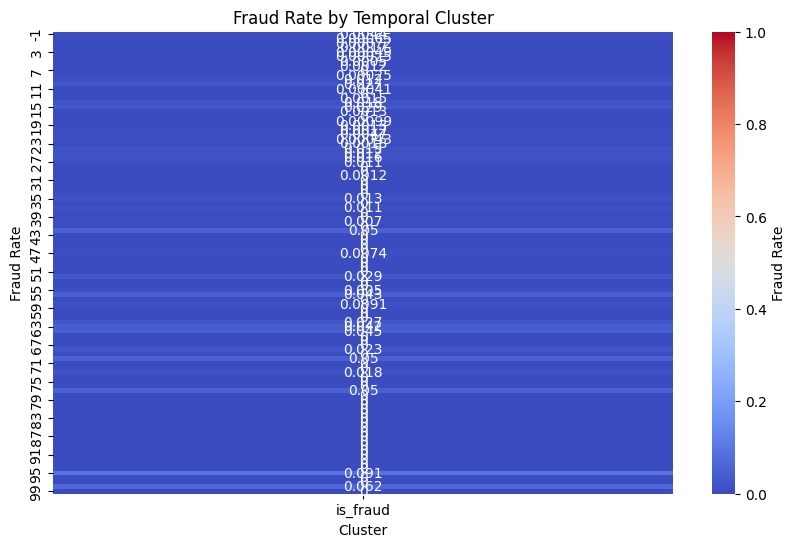

In [44]:
# compare is_fraud with temporal_cluster with heatmap

# Calculate fraud rate by cluster
fraud_by_cluster = train.groupby('temporal_cluster')['is_fraud'].mean()

# Visualize fraud rates by cluster
plt.figure(figsize=(10, 6))

# Plot the heatmap
sns.heatmap(fraud_by_cluster.to_frame(), annot=True, cmap='coolwarm', vmin=0, vmax=1, cbar_kws={'label': 'Fraud Rate'})
plt.title('Fraud Rate by Temporal Cluster')
plt.xlabel('Cluster')
plt.ylabel('Fraud Rate')
plt.show()

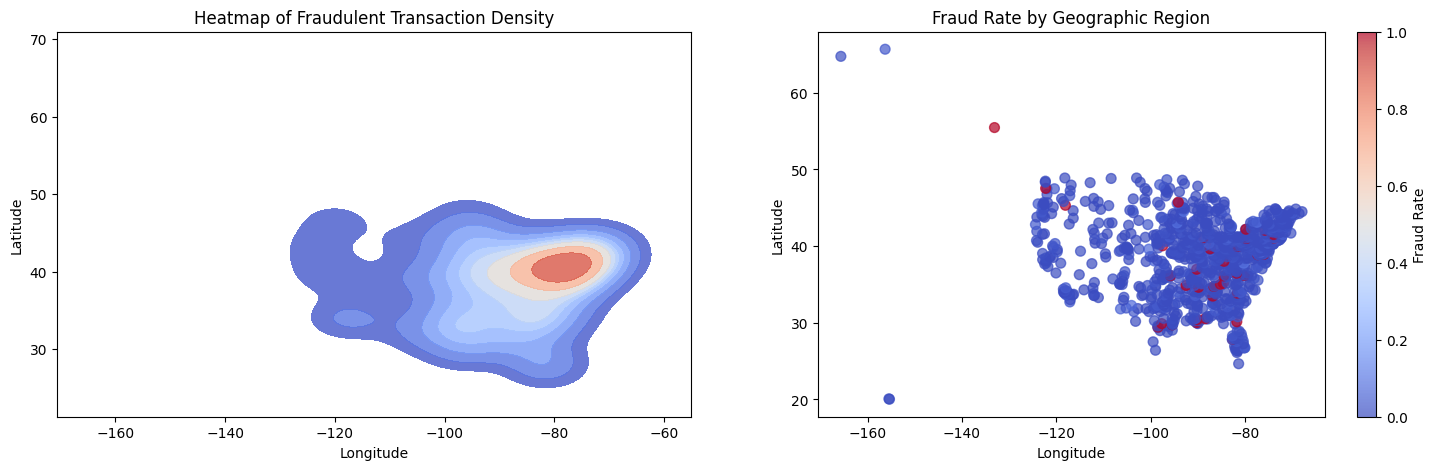

dbscan_labels
-1    0.142045
 0    0.005031
 1    0.000000
 2    0.000000
 3    0.029412
 4    0.285714
 5    0.500000
 6    0.222222
 7    0.000000
Name: is_fraud, dtype: float64


In [45]:
# Select features for clustering
features = train[['lat', 'long', 'amt']]

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
train['dbscan_labels'] = dbscan.fit_predict(features_scaled)

# Check the distribution of fraud in each cluster
fraud_distribution = train.groupby('dbscan_labels')['is_fraud'].mean()

# Filter data to include only clustered fraudulent points (exclude noise and non-fraud)
fraudulent_cluster_data = train[(train['dbscan_labels'] != -1) & (train['is_fraud'] == 1)]

# Prepare the data for the heatmap
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Heatmap for fraudulent transaction density
sns.kdeplot(
    data=fraudulent_cluster_data,
    x='long',
    y='lat',
    fill=True,
    cmap='coolwarm',
    alpha=0.8,     
    ax=axes[0],
)
axes[0].set_title('Heatmap of Fraudulent Transaction Density')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# Group by latitude and longitude rounded to 2 decimal places (to create regions)
train['lat_rounded'] = train['lat'].round(2)
train['long_rounded'] = train['long'].round(2)

# Calculate fraud rate by region
fraud_by_region = train.groupby(['lat_rounded', 'long_rounded'])['is_fraud'].mean().reset_index()

# Visualize fraud rates geographically
scatter = axes[1].scatter(fraud_by_region['long_rounded'], fraud_by_region['lat_rounded'], 
                          c=fraud_by_region['is_fraud'], cmap='coolwarm', s=50, alpha=0.7)
fig.colorbar(scatter, ax=axes[1], label='Fraud Rate')
axes[1].set_title('Fraud Rate by Geographic Region')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

plt.show()

print(fraud_distribution)


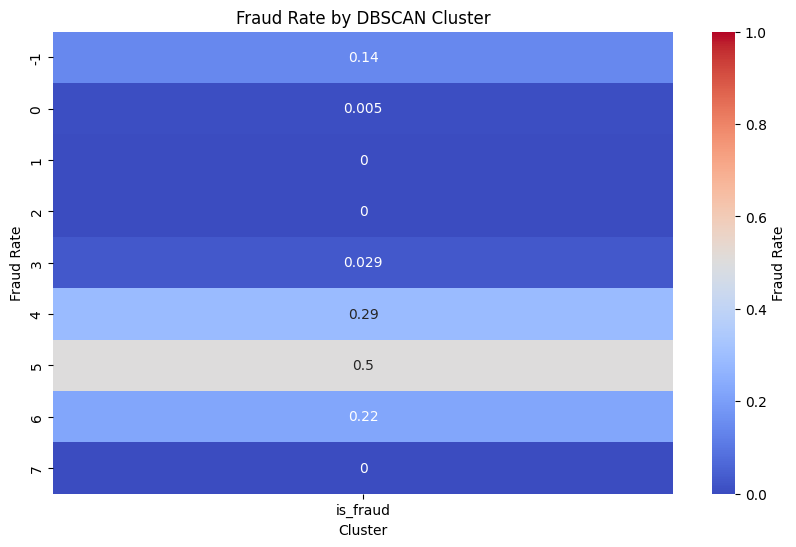

In [46]:
# compare is_fraud with dbscan_labels with heatmap

# Calculate fraud rate by cluster
fraud_by_cluster = train.groupby('dbscan_labels')['is_fraud'].mean()

# Visualize fraud rates by cluster
plt.figure(figsize=(10, 6))

# Plot the heatmap
sns.heatmap(fraud_by_cluster.to_frame(), annot=True, cmap='coolwarm', vmin=0, vmax=1, cbar_kws={'label': 'Fraud Rate'})
plt.title('Fraud Rate by DBSCAN Cluster')
plt.xlabel('Cluster')
plt.ylabel('Fraud Rate')
plt.show()


In [47]:
train['dbscan_labels'].value_counts()

dbscan_labels
 0    79511
-1      176
 1      156
 2       94
 3       34
 6        9
 5        8
 4        7
 7        5
Name: count, dtype: int64

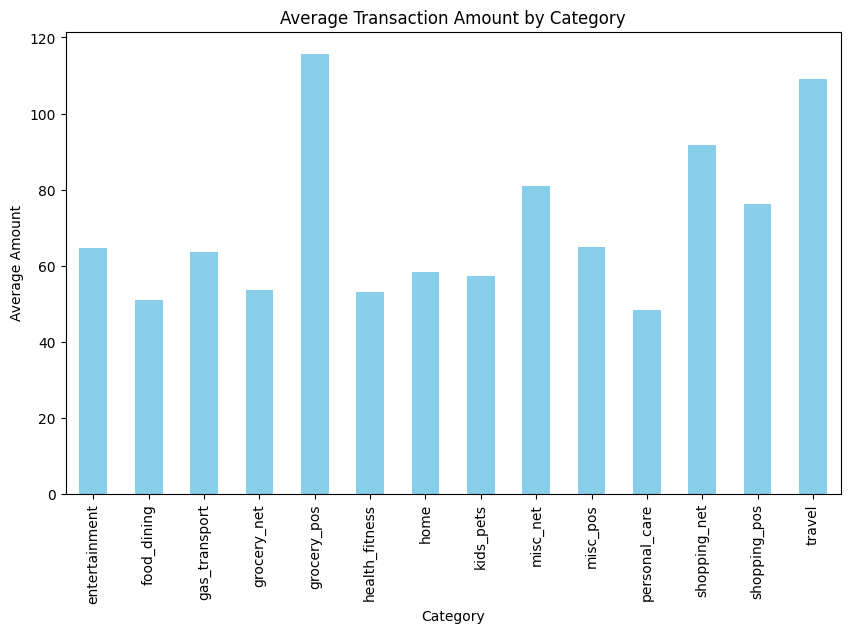

In [48]:
# make new feature for amount in each category

# Calculate average transaction amount by category

avg_amt_by_category = train.groupby('category')['amt'].mean()

# Visualize average transaction amount by category
plt.figure(figsize=(10, 6))
avg_amt_by_category.plot(kind='bar', color='skyblue')
plt.title('Average Transaction Amount by Category')
plt.xlabel('Category')
plt.ylabel('Average Amount')
plt.show()


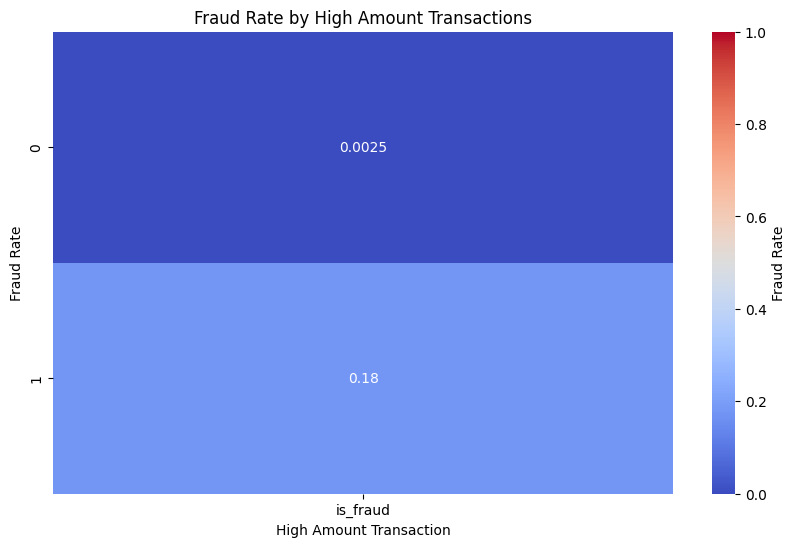

In [49]:
# new feature for if the amount is way above the average amount for that category

# Calculate average transaction amount by category
avg_amt_by_category = train.groupby('category')['amt'].mean()

# Create a new feature for high amount transactions
train['is_high_amt'] = train.apply(lambda x: 1 if x['amt'] > avg_amt_by_category[x['category']] * 5 else 0, axis=1)

# Calculate fraud rate by high amount transactions
fraud_by_high_amt = train.groupby('is_high_amt')['is_fraud'].mean()

# Visualize fraud rates by high amount transactions
plt.figure(figsize=(10, 6))
sns.heatmap(fraud_by_high_amt.to_frame(), annot=True, cmap='coolwarm', vmin=0, vmax=1, cbar_kws={'label': 'Fraud Rate'})
plt.title('Fraud Rate by High Amount Transactions')
plt.xlabel('High Amount Transaction')
plt.ylabel('Fraud Rate')
plt.show()

In [50]:
train['is_high_amt'].value_counts() 

is_high_amt
0    78683
1     1317
Name: count, dtype: int64

decent correlation definitely useful for pipeline

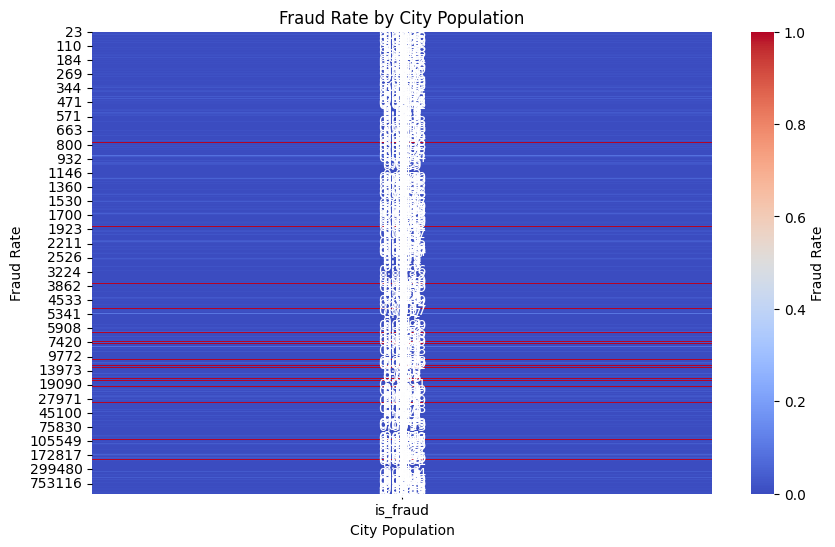

In [51]:
# amout of fraud by city population heatmap

# Calculate fraud rate by city population

fraud_by_city_pop = train.groupby('city_pop')['is_fraud'].mean()

# Visualize fraud rates by city population
plt.figure(figsize=(10, 6))

# Plot the heatmap
sns.heatmap(fraud_by_city_pop.to_frame(), annot=True, cmap='coolwarm', vmin=0, vmax=1, cbar_kws={'label': 'Fraud Rate'})

plt.title('Fraud Rate by City Population')
plt.xlabel('City Population')
plt.ylabel('Fraud Rate')
plt.show()



In [52]:
# make different cities very small (<1000), small (1000-10000), medium (10000-100000), large (100000-1000000), very large (>1000000)

# Create a new feature for city population size
train['city_size'] = pd.cut(train['city_pop'], bins=[0, 1000, 10000, 100000, 1000000, float('inf')], labels=['Very Small', 'Small', 'Medium', 'Large', 'Very Large'])

/var/folders/bp/tqx1fv0145x29m0h097lbn2r0000gp/T/ipykernel_10541/1797605243.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_by_city_size = train.groupby('city_size')['is_fraud'].mean()


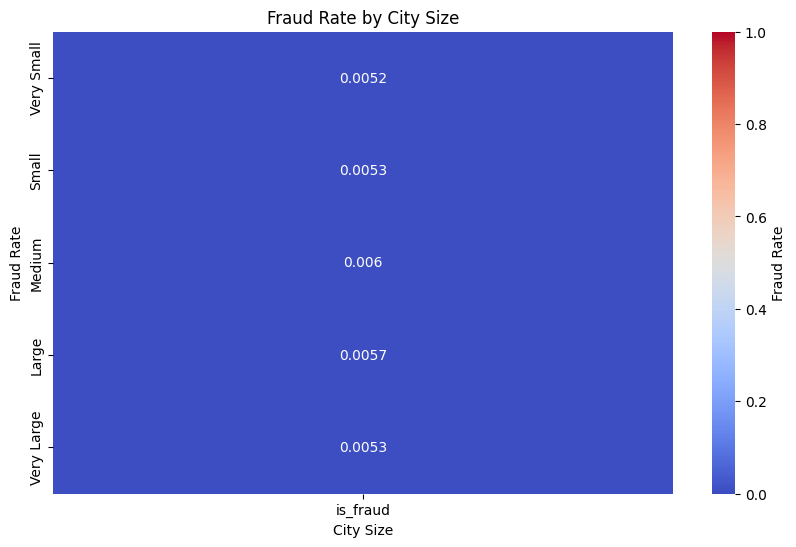

In [53]:
# Calculate fraud rate by city size with heatmap

# Calculate fraud rate by city size
fraud_by_city_size = train.groupby('city_size')['is_fraud'].mean()

# Visualize fraud rates by city size

plt.figure(figsize=(10, 6))
sns.heatmap(fraud_by_city_size.to_frame(), annot=True, cmap='coolwarm', vmin=0, vmax=1, cbar_kws={'label': 'Fraud Rate'})
plt.title('Fraud Rate by City Size')
plt.xlabel('City Size')
plt.ylabel('Fraud Rate')
plt.show()

Nothing by City size, but I still want to investivate by city a little bit more

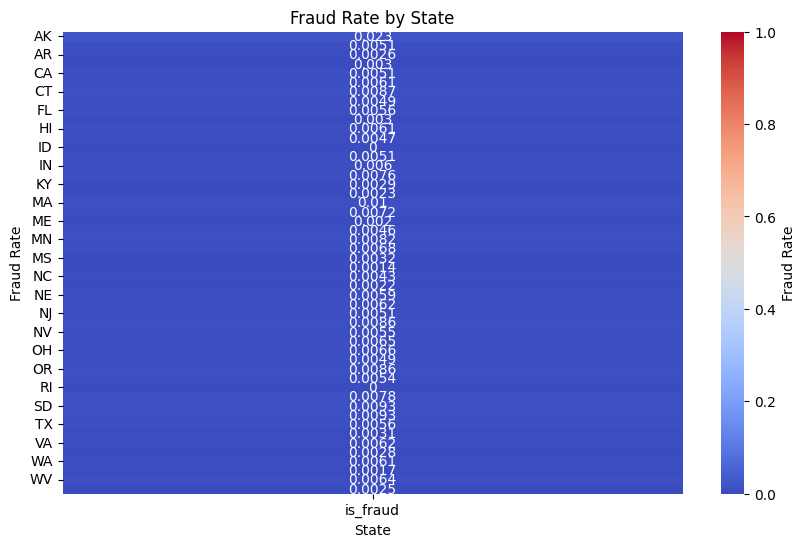

In [54]:
# heatmap of state and is_fraud

# Calculate fraud rate by state
fraud_by_state = train.groupby('state')['is_fraud'].mean()

# Visualize fraud rates by state
plt.figure(figsize=(10, 6))
sns.heatmap(fraud_by_state.to_frame(), annot=True, cmap='coolwarm', vmin=0, vmax=1, cbar_kws={'label': 'Fraud Rate'})
plt.title('Fraud Rate by State')
plt.xlabel('State')
plt.ylabel('Fraud Rate')
plt.show()

In [55]:
train['state'].value_counts()

state
TX    5860
NY    5102
PA    4959
CA    3514
OH    2865
MI    2850
IL    2758
FL    2666
AL    2553
MO    2366
MN    1959
AR    1944
NC    1865
SC    1790
VA    1772
WI    1770
IA    1720
KY    1717
GA    1684
IN    1672
OK    1639
WV    1556
NJ    1554
NE    1521
MD    1518
KS    1441
LA    1308
MS    1257
WY    1189
OR    1164
WA    1148
TN    1075
NM    1048
ME    1016
ND     890
CO     815
MA     791
SD     752
MT     724
VT     722
AZ     667
UT     649
NH     486
CT     462
NV     363
ID     331
DC     206
HI     163
AK     132
RI      27
Name: count, dtype: int64

only 7 transactions from delaware but every one was fraudulent.

In [56]:
train

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,log_amt,amt_bin,amt_top90,amt_bin_category,trans_hour,trans_hour_0,trans_hour_1,trans_hour_2,trans_hour_3,trans_hour_4,trans_hour_5,trans_hour_6,trans_hour_7,trans_hour_8,trans_hour_9,trans_hour_10,trans_hour_11,trans_hour_12,trans_hour_13,trans_hour_14,trans_hour_15,trans_hour_16,trans_hour_17,trans_hour_18,trans_hour_19,trans_hour_20,trans_hour_21,trans_hour_22,trans_hour_23,trans_year,trans_month,trans_2019_1,trans_2019_2,trans_2019_3,trans_2019_4,trans_2019_5,trans_2019_6,trans_2019_7,trans_2019_8,trans_2019_9,trans_2019_10,trans_2019_11,trans_2019_12,trans_2020_1,trans_2020_2,trans_2020_3,trans_2020_4,trans_2020_5,trans_2020_6,trans_2020_7,trans_2020_8,trans_2020_9,trans_2020_10,trans_2020_11,trans_2020_12,trans_week,trans_day,trans_minute,trans_second,is_peak_hour,is_peak_high_amt,weighted_peak_hour,day_of_week,season,is_weekend,is_night,amt_category,is_high_amt_male,male_peak_hour,weighted_gender_amt,is_high_amt_female,female_peak_hour,geo_cluster,temporal_cluster,dbscan_labels,lat_rounded,long_rounded,is_high_amt,city_size
769453,769453,2019-11-25 10:23:37,343668971234893,fraud_Friesen-D'Amore,gas_transport,78.16,Sally,Moore,F,835 Reese Views Suite 884,Hopkins,SC,29061,33.9349,-80.8449,13717,Chiropodist,1949-11-16,d31441e7924a9d4ced7e704e1a73f0e4,1353839017,33.990387,-80.951300,0,4.371471,Low,False,Low_gas_transport,10,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2019,11,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,48,25,23,37,0,0,0.00,0,Fall,0,0,medium,0,0,0.00,0,0,0,0,0,33.93,-80.84,0,Medium
1122154,1122154,2020-04-12 15:17:46,580954173374,fraud_Reilly LLC,home,46.18,Jessica,Benitez,F,31281 Thomas Inlet,Montrose,NY,10548,41.2496,-73.9446,3487,Race relations officer,1960-01-13,57d1e1ea208cd3688044bc7063d10d02,1365779866,41.032949,-74.367322,0,3.853970,Very Low,False,Very Low_home,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2020,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,15,12,17,46,0,0,0.00,6,Spring,0,0,low,0,0,0.00,0,0,0,1,0,41.25,-73.94,0,Small
365544,365544,2019-06-18 13:02:41,372520049757633,fraud_Pouros-Conroy,shopping_pos,145.98,Lori,Ramirez,F,4293 Ramirez Squares,Ranier,MN,56668,48.6031,-93.2977,136,Ceramics designer,2000-02-20,78b154f21c1299ae8fb6670207090009,1340024561,49.177089,-92.364430,0,4.990297,Medium,False,Medium_shopping_pos,13,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2019,6,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,18,2,41,0,0,0.00,1,Summer,0,0,high,0,0,0.00,0,0,0,2,0,48.60,-93.30,0,Very Small
553959,553959,2020-12-31 13:49:41,3590736522064285,"fraud_Nitzsche, Kessler and Wolff",shopping_pos,26.45,Kimberly,Gonzalez,F,72966 Shannon Pass Apt. 391,Bauxite,AR,72011,34.5091,-92.4828,4074,"Scientist, audiological",1975-12-20,e74cd23de7b688787c2bdbb59cecadf5,1388497781,34.357879,-91.983420,0,3.312366,Very Low,False,Very Low_shopping_pos,13,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2020,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,53,31,49,41,0,0,0.00,3,Winter,0,0,low,0,0,0.00,0,0,0,2,0,34.51,-92.48,0,Small
1010939,1010939,2020-02-20 17:33:28,4294040533480516,"fraud_Bins, Balistreri and Beatty",shopping_pos,1.57,Gail,Weaver,F,979 Stewart Lake,New Ellenton,SC,29809,33.4130,-81.6900,2206,Biomedical scientist,1986-12-31,806434cf934f0ea42557aa8f177ecab6,1361381608,34.400207,-82.529902,0,0.943906,Very Low,False,Very Low_shopping_pos,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2020,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,20,33,28,0,0,0.00,3,Winter,0,0,low,0,0,0.00,0,0,0,3,0,33.41,-81.69,0,Small
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

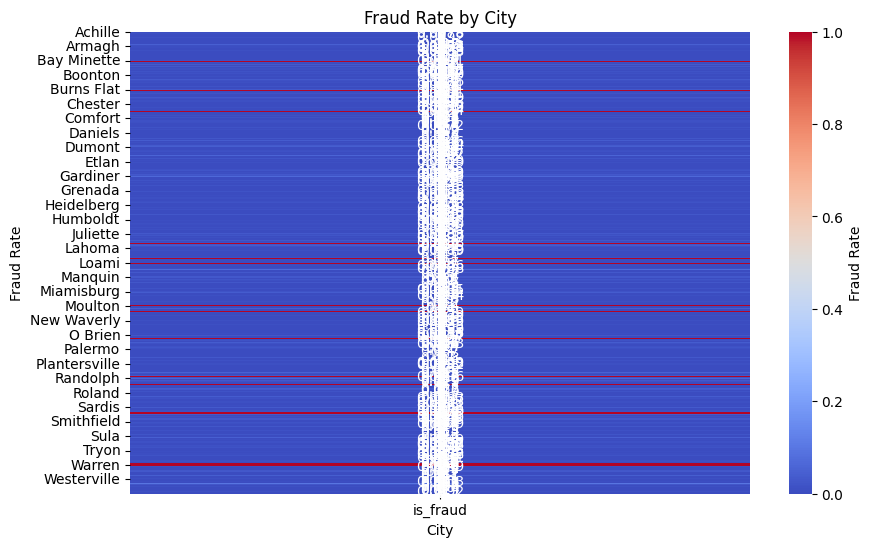

In [57]:
# city and is_fraud heatmap

# Calculate fraud rate by city
fraud_by_city = train.groupby('city')['is_fraud'].mean()

# Visualize fraud rates by city
plt.figure(figsize=(10, 6))

# Plot the heatmap
sns.heatmap(fraud_by_city.to_frame(), annot=True, cmap='coolwarm', vmin=0, vmax=1, cbar_kws={'label': 'Fraud Rate'})

plt.title('Fraud Rate by City')
plt.xlabel('City')
plt.ylabel('Fraud Rate')
plt.show()


# Data Analysis

## Analysis of Fraud Rate by Hour of Day

### Overview
The analysis of fraud rates by hour of day reveals a clear pattern of elevated fraudulent activity during specific hours. Understanding these temporal trends is critical for developing targeted fraud detection strategies.

### Key Observations
1. **Peak Fraud Hours:**
   - The **highest fraud rates occur between 10 PM and 11 PM**, indicating a significant spike in fraudulent activity during these hours.
   - Following this peak, fraud rates remain **consistently high from 12 AM to 3 AM**, albeit slightly lower than the 10-11 PM window.

2. **Lower Fraud Hours:**
   - Fraudulent activity drops sharply during **daytime hours**, with the lowest rates observed between **6 AM and 8 PM**.
   - These hours likely represent periods of routine and legitimate transaction behavior.

3. **Behavioral Insights:**
   - The elevated fraud rates during late-night hours (10 PM - 3 AM) suggest that fraudsters exploit this timeframe, possibly due to reduced monitoring or system vulnerabilities.


## Analysis of Weighted Peak Hour Feature

The `weighted_peak_hour` feature was created by combining the `is_peak_hour` feature (a binary indicator for transactions occurring between 10 PM and 3 AM) with the `amt` (transaction amount). The resulting feature aims to capture the interaction between the timing of transactions and their monetary value, hypothesizing that fraudulent transactions during peak hours might also have notable transaction amounts.

### Key Observations
1. **Correlation with Fraud (`is_fraud`):**
   - The `weighted_peak_hour` feature shows a **moderate positive correlation** with the `is_fraud` target variable, with a correlation coefficient of **0.38**.
   - This indicates that transactions that occur during peak hours and have higher amounts are somewhat associated with fraudulent behavior.

2. **Impact of Weighting:**
   - Weighting the `is_peak_hour` feature by `amt` significantly improved its correlation with `is_fraud` compared to the original unweighted `is_peak_hour` feature.
   - This suggests that transaction amount is a critical factor when analyzing fraudulent behavior during peak hours.

3. **Interpretation:**
   - Fraudsters are more likely to exploit peak hours for larger transaction amounts, possibly because these times are less monitored.
   - The combination of time and amount creates a stronger signal for detecting fraud compared to either feature individually.

## A Simple Example
Imagine someone tries to make a $5,000 transaction at 2 AM. Because it’s both a high amount and during peak fraud hours, our system would flag it as higher risk. This feature gives us a smarter way to catch these kinds of transactions.

- There doesn't seem to be any linear correlation with the time and day features, but that was within expectation, although it didn't hurt to check.

- males having high transactions is way more likely to be fraudulent than females.

## Fraud Rate by Geographic Cluster is super high, with Cluster 3 Hitting .75 Correlation
This analysis utilizes **DBSCAN clustering** to group transactions based on geographic and transaction-related features. By analyzing the fraud rate in each cluster, we aim to identify areas with high instances of fraudulent transactions.

#### Key Steps
1. **Clustering**:
   - Transactions were grouped into clusters using DBSCAN, a density-based clustering algorithm.
   - Geographic coordinates, transaction amounts, and peak hour indicators were used as features.

2. **Fraud Rate Calculation**:
   - For each cluster, the fraud rate was calculated as the proportion of fraudulent transactions within that cluster.

3. **Visualization**:
   - A heatmap was created to visualize the fraud rates of clusters. Clusters with higher fraud rates are highlighted in red, while lower fraud rates appear in blue.

### City information
   - Some cities had very high fraud rates. Something to take note of going into the pipeline. Could be a better feature to use than state or zip code.



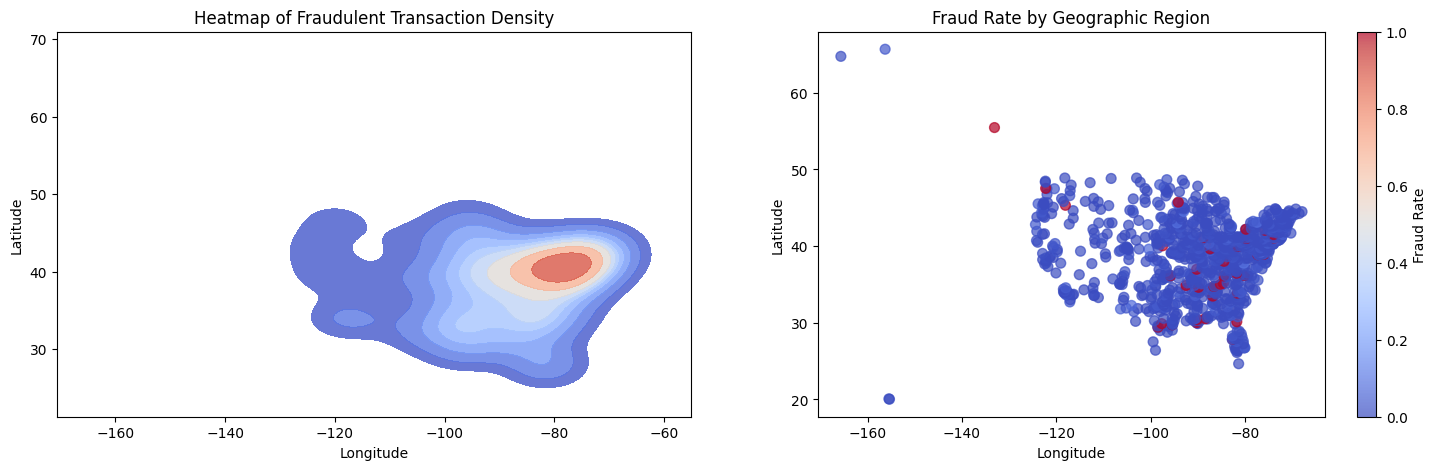

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Heatmap for fraudulent transaction density
sns.kdeplot(
    data=fraudulent_cluster_data,
    x='long',
    y='lat',
    fill=True,
    cmap='coolwarm',
    alpha=0.8,     
    ax=axes[0],
)
axes[0].set_title('Heatmap of Fraudulent Transaction Density')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# Group by latitude and longitude rounded to 2 decimal places (to create regions)
train['lat_rounded'] = train['lat'].round(2)
train['long_rounded'] = train['long'].round(2)

# Calculate fraud rate by region
fraud_by_region = train.groupby(['lat_rounded', 'long_rounded'])['is_fraud'].mean().reset_index()

# Visualize fraud rates geographically
scatter = axes[1].scatter(fraud_by_region['long_rounded'], fraud_by_region['lat_rounded'], 
                          c=fraud_by_region['is_fraud'], cmap='coolwarm', s=50, alpha=0.7)
fig.colorbar(scatter, ax=axes[1], label='Fraud Rate')
axes[1].set_title('Fraud Rate by Geographic Region')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

plt.show()

### Spatial Analysis of Fraudulent Transactions

#### Left Plot: Heatmap of Fraudulent Transaction Density
- **Description**: This heatmap focuses on the density of fraudulent transactions within clusters identified by the DBSCAN algorithm.
  - **Data Filter**: Only transactions marked as fraudulent (`is_fraud == 1`) within DBSCAN-identified clusters (`dbscan_labels != -1`) are included.
  - **Color Gradient**: Represents the density of fraudulent transactions:
    - **Red areas**: High density of fraudulent activity.
    - **Blue areas**: Low density or no fraudulent activity.
- **Purpose**: The heatmap provides a smooth, visual representation of fraudulent transaction density, highlighting specific geographic regions with higher concentrations of fraud within clusters.


#### Right Plot: Fraud Rate by Geographic Region
- **Description**: This scatter plot shows the average fraud rate calculated for geographic regions based on rounded latitude and longitude values.
  - **Color Gradient**: Indicates the fraud rate for each region:
    - **Red areas**: Regions with a high fraud rate.
    - **Blue areas**: Regions with a low fraud rate.
- **Data Aggregation**: Fraud rates are calculated as the mean of `is_fraud` for transactions grouped by latitude and longitude (rounded to 2 decimal places).
- **Purpose**: This plot identifies broader patterns of fraud prevalence across regions, complementing the cluster-level density analysis.


### Overall
1. **Fraudulent Transaction Hotspots:**
   - The left heatmap reveals specific areas with concentrated fraudulent transactions within the DBSCAN clusters.

2. **Regional Fraud Trends:**
   - The right scatter plot shows how fraud rates vary geographically.
   - Regions with consistently higher fraud rates (red points) may indicate systemic vulnerabilities or patterns exploited by fraudsters.

3. **Cluster vs. Region Analysis:**
   - The heatmap (left) offers a fine-grained view of fraudulent activity density within clusters, whereas the scatter plot (right) provides a broader view of regional fraud rates.

## Unused data:
- We looked into `age`, `names`, `seasons`, and few other custom features, but from what we looked at, none had any correlation towards our target label. 

In [59]:
train

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,log_amt,amt_bin,amt_top90,amt_bin_category,trans_hour,trans_hour_0,trans_hour_1,trans_hour_2,trans_hour_3,trans_hour_4,trans_hour_5,trans_hour_6,trans_hour_7,trans_hour_8,trans_hour_9,trans_hour_10,trans_hour_11,trans_hour_12,trans_hour_13,trans_hour_14,trans_hour_15,trans_hour_16,trans_hour_17,trans_hour_18,trans_hour_19,trans_hour_20,trans_hour_21,trans_hour_22,trans_hour_23,trans_year,trans_month,trans_2019_1,trans_2019_2,trans_2019_3,trans_2019_4,trans_2019_5,trans_2019_6,trans_2019_7,trans_2019_8,trans_2019_9,trans_2019_10,trans_2019_11,trans_2019_12,trans_2020_1,trans_2020_2,trans_2020_3,trans_2020_4,trans_2020_5,trans_2020_6,trans_2020_7,trans_2020_8,trans_2020_9,trans_2020_10,trans_2020_11,trans_2020_12,trans_week,trans_day,trans_minute,trans_second,is_peak_hour,is_peak_high_amt,weighted_peak_hour,day_of_week,season,is_weekend,is_night,amt_category,is_high_amt_male,male_peak_hour,weighted_gender_amt,is_high_amt_female,female_peak_hour,geo_cluster,temporal_cluster,dbscan_labels,lat_rounded,long_rounded,is_high_amt,city_size
769453,769453,2019-11-25 10:23:37,343668971234893,fraud_Friesen-D'Amore,gas_transport,78.16,Sally,Moore,F,835 Reese Views Suite 884,Hopkins,SC,29061,33.9349,-80.8449,13717,Chiropodist,1949-11-16,d31441e7924a9d4ced7e704e1a73f0e4,1353839017,33.990387,-80.951300,0,4.371471,Low,False,Low_gas_transport,10,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2019,11,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,48,25,23,37,0,0,0.00,0,Fall,0,0,medium,0,0,0.00,0,0,0,0,0,33.93,-80.84,0,Medium
1122154,1122154,2020-04-12 15:17:46,580954173374,fraud_Reilly LLC,home,46.18,Jessica,Benitez,F,31281 Thomas Inlet,Montrose,NY,10548,41.2496,-73.9446,3487,Race relations officer,1960-01-13,57d1e1ea208cd3688044bc7063d10d02,1365779866,41.032949,-74.367322,0,3.853970,Very Low,False,Very Low_home,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2020,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,15,12,17,46,0,0,0.00,6,Spring,0,0,low,0,0,0.00,0,0,0,1,0,41.25,-73.94,0,Small
365544,365544,2019-06-18 13:02:41,372520049757633,fraud_Pouros-Conroy,shopping_pos,145.98,Lori,Ramirez,F,4293 Ramirez Squares,Ranier,MN,56668,48.6031,-93.2977,136,Ceramics designer,2000-02-20,78b154f21c1299ae8fb6670207090009,1340024561,49.177089,-92.364430,0,4.990297,Medium,False,Medium_shopping_pos,13,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2019,6,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,18,2,41,0,0,0.00,1,Summer,0,0,high,0,0,0.00,0,0,0,2,0,48.60,-93.30,0,Very Small
553959,553959,2020-12-31 13:49:41,3590736522064285,"fraud_Nitzsche, Kessler and Wolff",shopping_pos,26.45,Kimberly,Gonzalez,F,72966 Shannon Pass Apt. 391,Bauxite,AR,72011,34.5091,-92.4828,4074,"Scientist, audiological",1975-12-20,e74cd23de7b688787c2bdbb59cecadf5,1388497781,34.357879,-91.983420,0,3.312366,Very Low,False,Very Low_shopping_pos,13,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2020,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,53,31,49,41,0,0,0.00,3,Winter,0,0,low,0,0,0.00,0,0,0,2,0,34.51,-92.48,0,Small
1010939,1010939,2020-02-20 17:33:28,4294040533480516,"fraud_Bins, Balistreri and Beatty",shopping_pos,1.57,Gail,Weaver,F,979 Stewart Lake,New Ellenton,SC,29809,33.4130,-81.6900,2206,Biomedical scientist,1986-12-31,806434cf934f0ea42557aa8f177ecab6,1361381608,34.400207,-82.529902,0,0.943906,Very Low,False,Very Low_shopping_pos,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2020,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,20,33,28,0,0,0.00,3,Winter,0,0,low,0,0,0.00,0,0,0,3,0,33.41,-81.69,0,Small
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

# For Pipeline

Things to drop:
- cc_num
- Unnamed: 0
- merchant 
- first
- last
- trans_num
- unix_time
- merch_lat
- merch_long 
- street
- state
- dob
- zip


New columns to create
- is peak hour (between 10pm and 3am from trans_date_trans_time)
- is high amount (category and high amount)
- weighted_peak_hour
- weighted_gender_amt 
- male_peak_hour
- is_high_amt_male
- weighted_peak_hour
(scale all of them that need to be scaled)

Things to one hot encode
- job
- city

In [60]:
class DropColumnsTransformer(BaseEstimator, TransformerMixin):
    """
    drops columns from a DataFrame
    """
    def __init__(self, columns):
        self.columns = columns 

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.columns, errors='ignore')

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return []  # If no input features are passed, return empty list
        return [col for col in input_features if col not in self.columns]


    

import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class AmtBinnerWithCategory(BaseEstimator, TransformerMixin):
    def __init__(self, bins=None, labels=None, multiplier=5):
        """
        Creates new features based if they are spending way more than the average amount for that category.
        """
        self.bins = bins if bins is not None else [0, 50, 100, 500, 1000, float('inf')]
        self.labels = labels if labels is not None else ['Very Low', 'Low', 'Medium', 'High', 'Very High']
        self.multiplier = multiplier
        self.encoded_columns = [] 
        self.avg_amt_by_category = None  
    
    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            # Calculate the average transaction amount by category
            self.avg_amt_by_category = X.groupby('category')['amt'].mean()
        return self
    
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            # Ensure required columns exist
            if not all(col in X.columns for col in ['amt', 'category']):
                raise ValueError("Missing required columns: 'amt' or 'category'")
            
            # Create amt_bin and amt_bin_category
            X['amt_bin'] = pd.cut(X['amt'], bins=self.bins, labels=self.labels)
            X['amt_bin_category'] = X['amt_bin'].astype(str) + "_" + X['category'].astype(str)
            
            # Perform one-hot encoding on amt_bin_category
            encoded_df = pd.get_dummies(X['amt_bin_category'], prefix='amt_bin_category').astype(int)
             # Store the encoded column names
            self.encoded_columns = encoded_df.columns.tolist() 
            
            # Add the one-hot encoded columns
            X = pd.concat([X, encoded_df], axis=1)

            # Create the 'is_high_amt' column: 1 if amt is significantly higher than category's average
            X['is_high_amt'] = X.apply(lambda x: 1 if x['amt'] > self.avg_amt_by_category[x['category']] * self.multiplier else 0, axis=1)

            X = X.drop(columns=['category', 'amt_bin', 'amt_bin_category', 'amt'])

        
        return X
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return self.encoded_columns + ['is_high_amt'] 
        return input_features + self.encoded_columns + ['is_high_amt'] 



class DBSCANTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, eps=0.5, min_samples=10, sample_size=None):
        """
        DBscan clustering transformer
        """
        self.eps = eps
        self.min_samples = min_samples
        self.sample_size = sample_size
        self.scaler = StandardScaler()
        self.dbscan = DBSCAN(eps=self.eps, min_samples=self.min_samples)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            # Ensure the columns exist in X before processing
            required_columns = ['lat', 'long', 'amt']
            if not all(col in X.columns for col in required_columns):
                raise ValueError(f"Missing required columns: {', '.join(required_columns)}")
            
            # Feature engineering: Peak hour calculation
            X['trans_hour'] = pd.to_datetime(X['trans_date_trans_time']).dt.hour
            X['is_peak_hour'] = X['trans_hour'].apply(lambda x: 1 if x >= 22 or x <= 3 else 0)
            X['weighted_peak_hour'] = X['is_peak_hour'] * X['amt']

            # Prepare features for clustering (only use relevant columns)
            features = X[['lat', 'long', 'amt', 'is_peak_hour']].copy()

            # Randomly sample if sample_size is provided
            if self.sample_size is not None and len(features) > self.sample_size:
                features = features.sample(n=self.sample_size, random_state=42)

            # Scale features and apply DBSCAN
            features_scaled = self.scaler.fit_transform(features)
            clusters = self.dbscan.fit_predict(features_scaled)

            # Map cluster labels back to the original data
            if self.sample_size is not None and len(features) < len(X):
                # Assign -1 (noise) for rows not included in the sample
                full_clusters = pd.Series(-1, index=X.index)
                full_clusters.loc[features.index] = clusters
                X['geo_cluster'] = full_clusters
            else:
                X['geo_cluster'] = clusters

            # Ensure geo_cluster is treated as an integer column
            X['geo_cluster'] = X['geo_cluster'].astype(int)

            # One-hot encode the geo_cluster column
            X = pd.get_dummies(X, columns=['geo_cluster'], prefix='cluster', dtype=int)

            # Only keep the geo_cluster columns (the one-hot encoded clusters)
            geo_cluster_columns = [col for col in X.columns if col.startswith('cluster_')]

            # Drop all other columns and keep only geo_cluster columns
            X = X[geo_cluster_columns]

        return X
    
    def get_feature_names_out(self, input_features=None):
        # Return only the cluster feature names (one-hot encoded columns)
        return [col for col in input_features if col.startswith('cluster_')] if input_features is not None else ['cluster_' + str(i) for i in range(-1, len(set(self.dbscan.labels_)))]




class SingleColumnBinaryTransformer(BaseEstimator, TransformerMixin):
    """
    Transformer to make any column that I want to be binary binary.
    """
    def __init__(self, column, positive_value):
        self.column = column
        self.positive_value = positive_value

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        binary_feature = np.where(X[self.column] == self.positive_value, 1, 0)
        return pd.DataFrame(binary_feature, columns=[f"{self.column}_binary"])

    # Add get_feature_names_out for compatibility with pipelines
    def get_feature_names_out(self, input_features=None):
        return [f"{self.column}_binary"]

class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        """
        Custom transformer to create additional features and scale them:
        - is_peak_hour
        - weighted_gender_amt
        - male_peak_hour
        - is_high_amt_male
        - weighted_peak_hour
        """
        self.scaler = StandardScaler()  # Initialize StandardScaler

    def fit(self, X, y=None):
        # No fitting is needed for this transformer, it's only used for feature engineering
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            # Ensure the required columns are present
            required_columns = ['gender', 'amt', 'trans_date_trans_time']
            if not all(col in X.columns for col in required_columns):
                raise ValueError(f"Missing required columns: {', '.join(required_columns)}")

            # Convert 'gender' to binary: 'M' becomes 1 and 'F' becomes 0
            X['gender'] = X['gender'].apply(lambda x: 1 if x == 'M' else 0)

            # Feature engineering: Create is_peak_hour based on transaction time
            X['trans_hour'] = pd.to_datetime(X['trans_date_trans_time']).dt.hour
            X['is_peak_hour'] = X['trans_hour'].apply(lambda x: 1 if x >= 22 or x <= 3 else 0)

            # Create the weighted_gender_amt column
            X['weighted_gender_amt'] = X['gender'] * X['amt']

            # Create the male_peak_hour column
            X['male_peak_hour'] = ((X['gender'] == 1) & (X['is_peak_hour'] == 1)).astype(int)

            # Create the is_high_amt_male column
            X['is_high_amt_male'] = ((X['gender'] == 1) & (X['amt'] > 1000)).astype(int)

            # Create the weighted_peak_hour column
            X['weighted_peak_hour'] = X['is_peak_hour'] * X['amt']
            
            # Drop the original columns used for feature engineering
            X = X.drop(columns=['gender', 'trans_date_trans_time', 'amt', 'trans_hour'])

            # Scale the new features
            numeric_columns = ['is_peak_hour', 'weighted_gender_amt', 'male_peak_hour', 
                               'is_high_amt_male', 'weighted_peak_hour']
            X[numeric_columns] = self.scaler.fit_transform(X[numeric_columns])

            # Keep only the necessary columns
            X = X[self.get_feature_names_out()]

        return X

    def get_feature_names_out(self, input_features=None):
        # Return the names of the newly created features
        return ['weighted_gender_amt', 'male_peak_hour', 'is_high_amt_male', 'weighted_peak_hour']

In [61]:
DroppableFeatures = ['cc_num', 'Unnamed: 0', 'merchant', 'first', 'last', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'street', 'state', 'dob', 'zip']
DBTransformer = ['trans_date_trans_time', 'lat', 'long']

In [62]:
# categorical features

categorical_features = [ 'gender', 'job', 'city' ]
numerical_features = ['city_pop', 'amt']

In [63]:
X_train

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long
769453,769453,2019-11-25 10:23:37,343668971234893,fraud_Friesen-D'Amore,gas_transport,78.16,Sally,Moore,F,835 Reese Views Suite 884,Hopkins,SC,29061,33.9349,-80.8449,13717,Chiropodist,1949-11-16,d31441e7924a9d4ced7e704e1a73f0e4,1353839017,33.990387,-80.951300
1122154,1122154,2020-04-12 15:17:46,580954173374,fraud_Reilly LLC,home,46.18,Jessica,Benitez,F,31281 Thomas Inlet,Montrose,NY,10548,41.2496,-73.9446,3487,Race relations officer,1960-01-13,57d1e1ea208cd3688044bc7063d10d02,1365779866,41.032949,-74.367322
365544,365544,2019-06-18 13:02:41,372520049757633,fraud_Pouros-Conroy,shopping_pos,145.98,Lori,Ramirez,F,4293 Ramirez Squares,Ranier,MN,56668,48.6031,-93.2977,136,Ceramics designer,2000-02-20,78b154f21c1299ae8fb6670207090009,1340024561,49.177089,-92.364430
553959,553959,2020-12-31 13:49:41,3590736522064285,"fraud_Nitzsche, Kessler and Wolff",shopping_pos,26.45,Kimberly,Gonzalez,F,72966 Shannon Pass Apt. 391,Bauxite,AR,72011,34.5091,-92.4828,4074,"Scientist, audiological",1975-12-20,e74cd23de7b688787c2bdbb59cecadf5,1388497781,34.357879,-91.983420
1010939,1010939,2020-02-20 17:33:28,4294040533480516,"fraud_Bins, Balistreri and Beatty",shopping_pos,1.57,Gail,Weaver,F,979 Stewart Lake,New Ellenton,SC,29809,33.4130,-81.6900,2206,Biomedical scientist,1986-12-31,806434cf934f0ea42557aa8f177ecab6,1361381608,34.400207,-82.529902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60823,60823,2019-02-05 12:04:08,2252055259910912,fraud_Abshire PLC,entertainment,67.99,Jason,Hernandez,M,220 Frank Gardens,Hewitt,WI,54441,44.6437,-90.1031,828,Arts development officer,1991-08-19,86a3d439978b7bb3c56a307ccd352ce1,1328443448,45.241358,-90.998022
264176,264176,2020-09-27 05:07:23,4147608975828480,"fraud_Stehr, Jewess and Schimmel",misc_net,5.48,Edward,Tapia,M,354 Gutierrez Gateway,Comfrey,MN,56019,44.1111,-94.9134,914,Health and safety adviser,1944-07-26,49b3c68fdd3e96a053378ca1af1a4c05,1380258443,44.767245,-94.816387
604130,604130,2019-09-14 04:36:32,4457732997086323466,fraud_Kilback LLC,grocery_pos,102.68,Stanley,Mayo,M,3433 Jones Branch,Fiddletown,CA,95629,38.5234,-120.6763,832,Immigration officer,1987-05-19,c9f16be8a857538bde0db8f9e6212336,1347597392,39.213489,-121.233694
141684,141684,2020-08-10 00:02:51,2719496466799416,fraud_Block-Parisian,misc_net,18.28,Sheila,Baker,F,8030 Walker Heights,Belle Fourche,SD,57717,44.6723,-103.8396,8007,Hospital pharmacist,1940-09-17,d36ced0d18fded7f7d46098ac3ce913c,1376092971,45.519231,-104.740074


In [64]:
categorical_transformer = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['city', 'job']),
        ('gender_transformer', SingleColumnBinaryTransformer(column='gender', positive_value='M'), ['gender'])

    ]
)

numerical_transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), ['amt', 'city_pop'])
    ]
)

# DBSCAN transformer pipeline
dbscan_transformer = DBSCANTransformer()

# Define the main preprocessor pipeline
preprocessor = Pipeline(steps=[
    ('pre', ColumnTransformer(
        transformers=[
            ('drop', DropColumnsTransformer(columns=DroppableFeatures), DroppableFeatures),
            ('num', numerical_transformer, numerical_features),
            ('FETransformer', FeatureEngineeringTransformer(), ['gender', 'amt', 'trans_date_trans_time']),
            ('DBScan', dbscan_transformer, ['trans_date_trans_time', 'lat', 'long', 'amt']), 
            ('amtBinner', AmtBinnerWithCategory(), ['amt', 'category']),
            ('cat', categorical_transformer, categorical_features),

        ],
        remainder='passthrough',
    )),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42)))

])

preprocessor


Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop',
                                                  DropColumnsTransformer(columns=['cc_num',
                                                                                  'Unnamed: '
                                                                                  '0',
                                                                                  'merchant',
                                                                                  'first',
                                                                                  'last',
                                                                                  'trans_num',
                                                                                  'unix_time',
                                                                                  'merch_lat',
                                                                                  'merch_long',
                                                                                  'street',
                                                                                  'state',
                                                                                  'dob',
                                                                                  'zip']),
                                                  ['cc_num', 'Unnamed: 0',
                                                   'merchant', 'first', 'last',
                                                   'trans_num', 'unix_time',
                                                   'merch_lat', 'merch_long',
                                                   'stre...
                                                  ['amt', 'category']),
                                                 ('cat',
                                                  ColumnTransformer(transformers=[('encoder',
                                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                                 sparse_output=False),
                                                                                   ['city',
                                                                                    'job']),
                                                                                  ('gender_transformer',
                                                                                   SingleColumnBinaryTransformer(column='gender',
                                                                                                                 positive_value='M'),
                                                                                   ['gender'])]),
                                                  ['gender', 'job', 'city'])])),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=42)))])

In [65]:
# Apply the preprocessor to the sampled data
X_transformed = preprocessor.fit_transform(X_train, y_train)

# Convert the transformed output to a DataFrame
X_transformed_df = pd.DataFrame(X_transformed)

X_transformed_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118
0,0.049595,-0.252533,-0.282088,-0.348817,-0.037107,-0.233548,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.146920,-0.286297,-0.282088,-0.348817,-0.037107,-0.233548,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.466346,-0.297357,-0.282088,-0.348817,-0.037107,-0.233548,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.268160,-0.284360,-0.282088,-0.348817,-0.037107,-0.233548,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.421046,-0.290525,-0.282088,-0.348817,-0.037107,-0.233548,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,-0.012899,-0.295073,0.324319,-0.348817,-0.037107,-0.233548,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
79996,-0.397019,-0.294789,-0.233211,-0.348817,-0.037107,-0.233548,0.

# PIPELINE

For the pipeline, the first thing we did was remove all features that we deemed unneccecary based off of our exploration or would not be used in creating new features.
These features included:
- cc_num 
- Unnamed: 0 
- merchant
- first 
- last
- trans_num 
- unix_time
- merch_lat 
- merch_long
- street 
- state 
- dob
- city_pop 
- zip 
- lat
- long

Next, we scaled numerical features, the 2 features we scaled in this were amt and city_pop (other features were scaled but in custom transformers).

Next I created a custom transformer to create and scale the new features we talked about in the exploration:
- weighted_gender_amt
- male_peak_hour
- is_high_amt_male 
- weighted_peak_hour

Next I created a custom transformer to do the DBscan for the pipeline

This creates cluster transactions geographically and identify fraud-prone areas using DBSCAN. This transformer incorporates geographic (lat, long) and transactional (amt) features to produce  clusters.

Next I made a custom transformer called AMTBinner, which creates the new feature called "is high amount" 

I also created a categorical transformer to OHE city and job. We chose to use city over state and zip code because it gives more in depth information of potentail fraud areas than state, but also isnt as likely to overfit as zip code is.

Last, we did a random forest at the end of the model to drop all useless features. That left us with 119 columns






In [66]:
# confirm everything is scaled

X_transformed_df.describe()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118
count,8.000000e+04,8.000000e+04,8.000000e+04,8.000000e+04,8.000000e+04,8.000000e+04,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,-1.492140e-17,6.217249e-19,2.255973e-17,-5.044853e-17,-6.572520e-18,5.311307e-17,0.006650,0.758550,0.230050,0.000888,0.000200,0.000125,0.000162,0.001575,0.001012,0.002075,0.002125,0.001788,0.079525,0.005375,0.013062,0.009175,0.052687,0.013375,0.008913,0.009725,0.009612,0.016813,0.000188,0.001500,0.001025,0.000387,0.020262,0.017225,0.037163,0.048738,0.047587,0.031137,0.045525,0.044100,0.052637,0.065562,0.026863,0.016463,0.000013,0.000763,0.001613,0.000013,0.001038,0.001575,0.002012,0.000013,0.002725,0.000825,0.001213,0.000013,0.000013,0.000362,0.001362,0.000625,0.000013,0.001388,0.000013,0.001337,0.002025,0.002012,0.000013,0.000013,0.004063,0.000025,0.001975,0.000438,0.001925,0.000913,0.000013,0.000013,0.000013,0.000387,0.002087,0.000025,0.001025,0.000025,0.003462,0.004625,0.002012,0.002025,0.000400,0.005150,0.000013,0.003987,0.000013,0.002225,0.004262,0.004262,0.000013,0.002900,0.007313,0.004363,0.000350,0.000013,0.001725,0.001400,0.002012,0.002138,0.004513,0.003875,0.001388,0.001613,0.003687,0.003050,0.004700,0.000013,0.005213,0.006712,0.006550,0.000350,0.000438,0.003275,0.453512
std,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,0.081276,0.427965,0.420867,0.029778,0.014141,0.011180,0.012747,0.039655,0.031804,0.045505,0.046049,0.042241,0.270558,0.073118,0.113543,0.095346,0.223410,0.114875,0.093985,0.098135,0.097572,0.128569,0.013692,0.038701,0.031999,0.019681,0.140898,0.130110,0.189161,0.215320,0.212893,0.173690,0.208454,0.205319,0.223310,0.247517,0.161683,0.127247,0.003536,0.027603,0.040124,0.003536,0.032194,0.039655,0.044816,0.003536,0.052131,0.028711,0.034800,0.003536,0.003536,0.019036,0.036887,0.024992,0.003536,0.037224,0.003536,0.036548,0.044955,0.044816,0.003536,0.003536,0.063609,0.005000,0.044397,0.020912,0.043833,0.030194,0.003536,0.003536,0.003536,0.019681,0.045642,0.005000,0.031999,0.005000,0.058741,0.067850,0.044816,0.044955,0.019996,0.071579,0.003536,0.063021,0.003536,0.047118,0.065149,0.065149,0.003536,0.053774,0.085200,0.065905,0.018705,0.003536,0.041498,0.037391,0.044816,0.046184,0.067024,0.06

In [67]:
# random letters so that if I click run all it doesn't run the next cell

lkjllkjlkj

NameError: name 'lkjllkjlkj' is not defined

# Random Forests

In [ ]:
# Create the RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)

# Perform cross-validation predictions
y_train_pred_cv_rf = cross_val_predict(rf_clf, X_transformed, y_train, cv=5)

# Calculate cross-validated scores
precision_cv_rf = precision_score(y_train, y_train_pred_cv_rf)
recall_cv_rf = recall_score(y_train, y_train_pred_cv_rf)
f1_cv_rf = f1_score(y_train, y_train_pred_cv_rf)

print(f"Cross-Validated Precision: {precision_cv_rf:.4f}")
print(f"Cross-Validated Recall: {recall_cv_rf:.4f}")
print(f"Cross-Validated F1 Score: {f1_cv_rf:.4f}")

Cross-Validated Precision: 0.8722
Cross-Validated Recall: 0.7074
Cross-Validated F1 Score: 0.7812


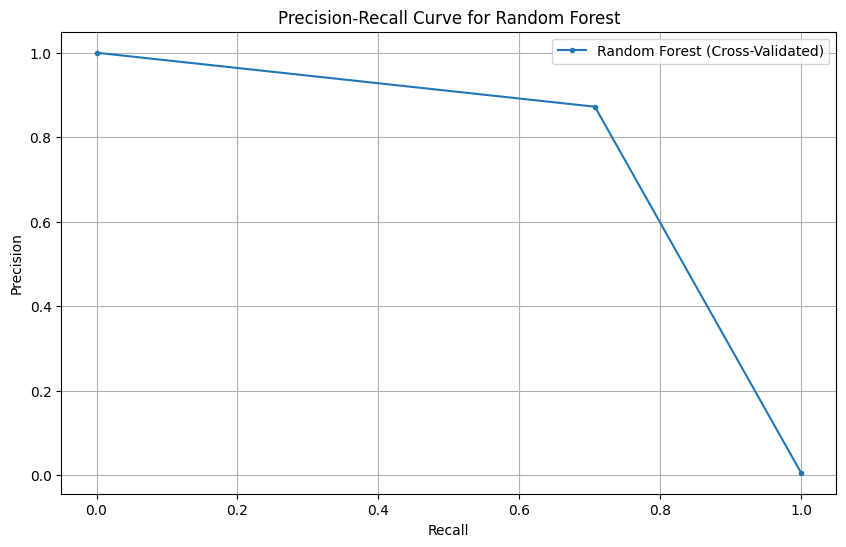

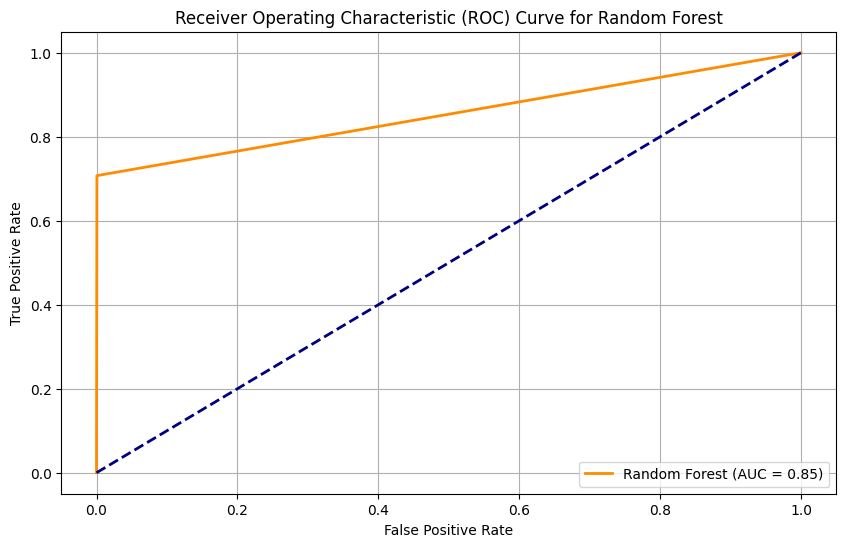

In [ ]:
# Calculate precision and recall values
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_train, y_train_pred_cv_rf)

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall_rf, precision_rf, marker='.', label='Random Forest (Cross-Validated)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Random Forest')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_train_pred_cv_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Logistic Regression

In [ ]:
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

# Perform cross-validation predictions
y_train_pred_cv_log_reg = cross_val_predict(log_reg, X_transformed, y_train, cv=cv)

# Calculate cross-validated scores
precision_cv_log_reg = precision_score(y_train, y_train_pred_cv_log_reg)
recall_cv_log_reg = recall_score(y_train, y_train_pred_cv_log_reg)
f1_cv_log_reg = f1_score(y_train, y_train_pred_cv_log_reg)

# Print cross-validated scores
print(f"Cross-Validated Precision: {precision_cv_log_reg:.4f}")
print(f"Cross-Validated Recall: {recall_cv_log_reg:.4f}")
print(f"Cross-Validated F1 Score: {f1_cv_log_reg:.4f}")

Precision: 0.7455
Recall: 0.3848
F1 Score: 0.5076
AUC: 0.6920
Cross-Validated Precision: 0.7455
Cross-Validated Recall: 0.3848
Cross-Validated F1 Score: 0.5076


In [ ]:
# Create the SGDClassifier model
sgd_clf = SGDClassifier(random_state=42)

# Perform cross-validation predictions
y_train_pred_cv_sgd = cross_val_predict(sgd_clf, X_transformed, y_train, cv=5)

# Calculate and print the scores
precision = precision_score(y_train, y_train_pred_cv_sgd)
recall = recall_score(y_train, y_train_pred_cv_sgd)
f1 = f1_score(y_train, y_train_pred_cv_sgd)
roc_auc = roc_auc_score(y_train, y_train_pred_cv_sgd)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {roc_auc:.4f}")
# Perform cross-validation predictions with the best estimator
y_train_pred_cv_best_SGD = cross_val_predict(sgd_clf, X_transformed, y_train, cv=5)

# Calculate cross-validated scores
precision_cv_sgd = precision_score(y_train, y_train_pred_cv_sgd)
recall_cv_sgd = recall_score(y_train, y_train_pred_cv_sgd)
f1_cv_sgd = f1_score(y_train, y_train_pred_cv_sgd)

print(f"Cross-Validated Precision: {precision_cv_sgd:.4f}")
print(f"Cross-Validated Recall: {recall_cv_sgd:.4f}")
print(f"Cross-Validated F1 Score: {f1_cv_sgd:.4f}")

Precision: 0.5966
Recall: 0.3272
F1 Score: 0.4226
AUC: 0.6630
Cross-Validated Precision: 0.5966
Cross-Validated Recall: 0.3272
Cross-Validated F1 Score: 0.4226


In [ ]:
# Create the DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Perform cross-validation predictions
y_train_pred_cv_dt = cross_val_predict(dt_clf, X_transformed, y_train, cv=5)


# Calculate cross-validated scores
precision_cv_dt = precision_score(y_train, y_train_pred_cv_dt)
recall_cv_dt = recall_score(y_train, y_train_pred_cv_dt)
f1_cv_dt = f1_score(y_train, y_train_pred_cv_dt)

print(f"Cross-Validated Precision: {precision_cv_dt:.4f}")
print(f"Cross-Validated Recall: {recall_cv_dt:.4f}")
print(f"Cross-Validated F1 Score: {f1_cv_dt:.4f}")




Cross-Validated Precision: 0.7327
Cross-Validated Recall: 0.7074
Cross-Validated F1 Score: 0.7198


In [ ]:
# Create the LinearSVC model
linear_svc = LinearSVC(random_state=42, max_iter=10000)

# Perform cross-validation predictions
y_train_pred_cv_linear_svc = cross_val_predict(linear_svc, X_transformed, y_train, cv=5)


# Calculate cross-validated scores
precision_cv_linear_svc = precision_score(y_train, y_train_pred_cv_linear_svc)
recall_cv_linear_svc = recall_score(y_train, y_train_pred_cv_linear_svc)
f1_cv_linear_svc = f1_score(y_train, y_train_pred_cv_linear_svc)

print(f"Cross-Validated Precision: {precision_cv_linear_svc:.4f}")
print(f"Cross-Validated Recall: {recall_cv_linear_svc:.4f}")
print(f"Cross-Validated F1 Score: {f1_cv_linear_svc:.4f}")

Cross-Validated Precision: 0.7627
Cross-Validated Recall: 0.4147
Cross-Validated F1 Score: 0.5373


# KNN

In [ ]:
# Create the KNeighborsClassifier model
knn_clf = KNeighborsClassifier()

# Perform cross-validation predictions
y_train_pred_cv_knn = cross_val_predict(knn_clf, X_transformed, y_train, cv=5)


# Calculate cross-validated scores
precision_cv_knn = precision_score(y_train, y_train_pred_cv_knn)
recall_cv_knn = recall_score(y_train, y_train_pred_cv_knn)
f1_cv_knn = f1_score(y_train, y_train_pred_cv_knn)

print(f"Cross-Validated Precision: {precision_cv_knn:.4f}")
print(f"Cross-Validated Recall: {recall_cv_knn:.4f}")
print(f"Cross-Validated F1 Score: {f1_cv_knn:.4f}")

Cross-Validated Precision: 0.8204
Cross-Validated Recall: 0.6843
Cross-Validated F1 Score: 0.7462


# SVC

In [ ]:


# Create the SVC model
svc_clf = SVC(probability=True, random_state=42)

# Perform cross-validation predictions
y_train_pred_cv_svc = cross_val_predict(svc_clf, X_transformed, y_train, cv=5)

# Calculate cross-validated scores
precision_cv_svc = precision_score(y_train, y_train_pred_cv_svc)
recall_cv_svc = recall_score(y_train, y_train_pred_cv_svc)
f1_cv_svc = f1_score(y_train, y_train_pred_cv_svc)

print(f"Cross-Validated Precision: {precision_cv_svc:.4f}")
print(f"Cross-Validated Recall: {recall_cv_svc:.4f}")
print(f"Cross-Validated F1 Score: {f1_cv_svc:.4f}")

Cross-Validated Precision: 0.8367
Cross-Validated Recall: 0.5783
Cross-Validated F1 Score: 0.6839


# XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import cross_val_predict

# Create the XGBoost classifier
xgb_clf = xgb.XGBClassifier(random_state=42)

# Perform cross-validation predictions
y_train_pred_cv_xgb = cross_val_predict(xgb_clf, X_transformed, y_train, cv=5)

# Calculate cross-validated scores
precision_cv_xgb = precision_score(y_train, y_train_pred_cv_xgb)
recall_cv_xgb = recall_score(y_train, y_train_pred_cv_xgb)
f1_cv_xgb = f1_score(y_train, y_train_pred_cv_xgb)
roc_auc_cv_xgb = roc_auc_score(y_train, y_train_pred_cv_xgb)

print(f"Cross-Validated Precision: {precision_cv_xgb:.4f}")
print(f"Cross-Validated Recall: {recall_cv_xgb:.4f}")
print(f"Cross-Validated F1 Score: {f1_cv_xgb:.4f}")
print(f"Cross-Validated ROC AUC Score: {roc_auc_cv_xgb:.4f}")

Cross-Validated Precision: 0.8302
Cross-Validated Recall: 0.7097
Cross-Validated F1 Score: 0.7652
Cross-Validated ROC AUC Score: 0.8544


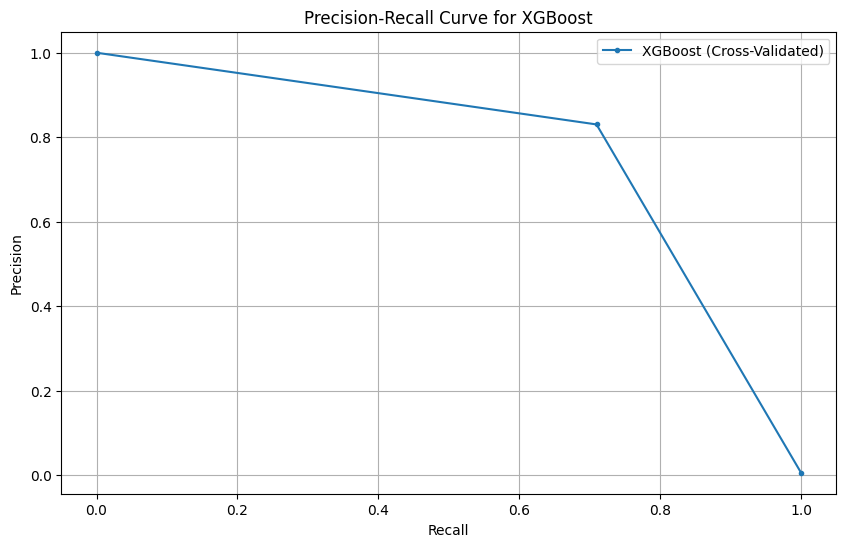

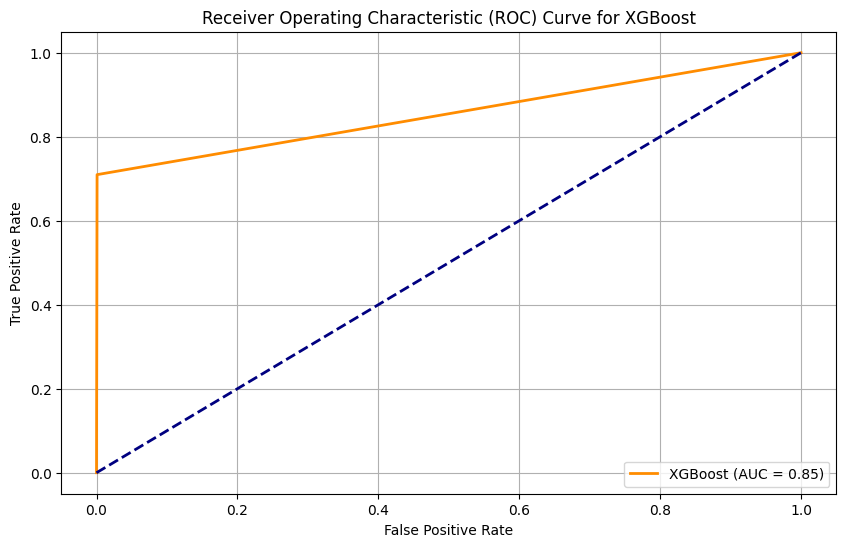

In [ ]:
# Calculate precision and recall values
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_train, y_train_pred_cv_xgb)

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall_xgb, precision_xgb, marker='.', label='XGBoost (Cross-Validated)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for XGBoost')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the ROC curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_train, y_train_pred_cv_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for XGBoost')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score

# Create the GaussianNB model
nb_clf = GaussianNB()

# Perform cross-validation predictions
y_train_pred_cv_nb = cross_val_predict(nb_clf, X_transformed, y_train, cv=5)

# Calculate cross-validated scores
precision_cv_nb = precision_score(y_train, y_train_pred_cv_nb)
recall_cv_nb = recall_score(y_train, y_train_pred_cv_nb)
f1_cv_nb = f1_score(y_train, y_train_pred_cv_nb)

print(f"Cross-Validated Precision: {precision_cv_nb:.4f}")
print(f"Cross-Validated Recall: {recall_cv_nb:.4f}")
print(f"Cross-Validated F1 Score: {f1_cv_nb:.4f}")

Cross-Validated Precision: 0.0751
Cross-Validated Recall: 0.6313
Cross-Validated F1 Score: 0.1342


The best cross validation scores that allign most with our business goal (high recall but also not insanely low precisiom) were from Random Foest, KNN, and XGboost. We will fine tune these models in the next steps.

# Fine-Tuning Models

## Random Forests

In [ ]:
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [10,15,20,30],
    'min_samples_split': [2, 5, 10, 20, 40, 60, 80],
    'min_samples_leaf': [1, 2, 5, 10, 20, 30],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True],
    'class_weight': ['balanced']
}

# Define the scoring metrics
scoring = {
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=rf_clf, 
    param_distributions=param_grid, 
    n_iter=20, 
    scoring=scoring, 
    refit='f1', 
    cv=cv, 
    random_state=42, 
    n_jobs=-1, 
    verbose=1
)

# Fit the random search model
random_search.fit(X_transformed, y_train)

# Get the best estimator
best_rf_clf = random_search.best_estimator_

# Print the best parameters
print("Best parameters found: ", random_search.best_params_)

# Predict on the training set
y_train_pred = best_rf_clf.predict(X_transformed)

# Calculate and print the scores
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
f1 = f1_score(y_train, y_train_pred)
roc_auc = roc_auc_score(y_train, y_train_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {roc_auc:.4f}")
# Perform cross-validation predictions with the best estimator
y_train_pred_cv_best_rf = cross_val_predict(best_rf_clf, X_transformed, y_train, cv=5)

# Calculate cross-validated scores for the best estimator
precision_cv_best_rf = precision_score(y_train, y_train_pred_cv_best_rf)
recall_cv_best_rf = recall_score(y_train, y_train_pred_cv_best_rf)
f1_cv_best_rf = f1_score(y_train, y_train_pred_cv_best_rf)

print(f"Cross-Validated Precision (Best RF): {precision_cv_best_rf:.4f}")
print(f"Cross-Validated Recall (Best RF): {recall_cv_best_rf:.4f}")
print(f"Cross-Validated F1 Score (Best RF): {f1_cv_best_rf:.4f}")

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best parameters found:  {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'class_weight': 'balanced', 'bootstrap': True}
Precision: 0.3932
Recall: 0.9931
F1 Score: 0.5634
AUC: 0.9924
Cross-Validated Precision (Best RF): 0.3575
Cross-Validated Recall (Best RF): 0.8871
Cross-Validated F1 Score (Best RF): 0.5096


In [68]:
# Custom scoring function to prioritize recall while ensuring precision is >= 40%
def custom_scorer(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    
    # Enforce precision >= 40%
    if precision >= 0.4:
        return recall  # Prioritize recall
    else:
        return -1 

# Define the parameter grid based on the best parameters found
param_grid_rf = {
    'n_estimators': [100, 200, 250],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt'],
    'max_depth': [30],
    'class_weight': ['balanced'],
    'bootstrap': [True]
}

# Create the RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

# Create the GridSearchCV object with the custom scorer
grid_search_rf = GridSearchCV(
    estimator=rf_clf, 
    param_grid=param_grid_rf, 
    scoring=make_scorer(custom_scorer),  
    refit='f1',  
    cv=cv, 
    n_jobs=-1, 
    verbose=1
)

# Fit the grid search model
grid_search_rf.fit(X_transformed, y_train)

# Get the best estimator
best_rf_clf = grid_search_rf.best_estimator_

# Print the best parameters
print("Best parameters found: ", grid_search_rf.best_params_)

# Predict on the training set
y_train_pred = best_rf_clf.predict(X_transformed)

# Calculate and print the scores
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
f1 = f1_score(y_train, y_train_pred)
roc_auc = roc_auc_score(y_train, y_train_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {roc_auc:.4f}")

# Perform cross-validation predictions with the best estimator
from sklearn.model_selection import cross_val_predict

y_train_pred_cv_best_rf = cross_val_predict(best_rf_clf, X_transformed, y_train, cv=5)

# Calculate cross-validated scores for the best estimator
precision_cv_best_rf = precision_score(y_train, y_train_pred_cv_best_rf)
recall_cv_best_rf = recall_score(y_train, y_train_pred_cv_best_rf)
f1_cv_best_rf = f1_score(y_train, y_train_pred_cv_best_rf)

print(f"Cross-Validated Precision (Best RF): {precision_cv_best_rf:.4f}")
print(f"Cross-Validated Recall (Best RF): {recall_cv_best_rf:.4f}")
print(f"Cross-Validated F1 Score (Best RF): {f1_cv_best_rf:.4f}")

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Best parameters found:  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 250}
Precision: 0.7414
Recall: 0.9977
F1 Score: 0.8507
AUC: 0.9979
Cross-Validated Precision (Best RF): 0.6519
Cross-Validated Recall (Best RF): 0.8157
Cross-Validated F1 Score (Best RF): 0.7247


In [ ]:
# Create the RandomForestClassifier
rf_clf = RandomForestClassifier(
    n_estimators=250,
    min_samples_split=15,
    min_samples_leaf=1,
    max_features='sqrt',
    max_depth=30,
    class_weight='balanced',
    bootstrap=True,
    random_state=42
)

# Perform cross-validation predictions
y_train_pred_cv_rf = cross_val_predict(rf_clf, X_transformed, y_train, cv=5)


# Calculate cross-validated scores
precision_cv_rf = precision_score(y_train, y_train_pred_cv_rf)
recall_cv_rf = recall_score(y_train, y_train_pred_cv_rf)
f1_cv_rf = f1_score(y_train, y_train_pred_cv_rf)

print(f"Cross-Validated Precision: {precision_cv_rf:.4f}")
print(f"Cross-Validated Recall: {recall_cv_rf:.4f}")
print(f"Cross-Validated F1 Score: {f1_cv_rf:.4f}")
print(f"Cross-Validated ROC AUC Score: {roc_auc_score(y_train, y_train_pred_cv_rf):.4f}")

Cross-Validated Precision: 0.6519
Cross-Validated Recall: 0.8157
Cross-Validated F1 Score: 0.7247
Cross-Validated ROC AUC Score: 0.9066


## K-Neighbors

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, roc_auc_score

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Create the KNeighborsClassifier model
knn_clf = KNeighborsClassifier()

# Create the RandomizedSearchCV object with the custom scorer
random_search_knn = RandomizedSearchCV(
    estimator=knn_clf, 
    param_distributions=param_grid, 
    n_iter=20, 
    scoring=make_scorer(custom_scorer),  
    refit='f1', 
    cv=cv, 
    random_state=42, 
    n_jobs=-1, 
    verbose=1
)

# Fit the random search model
random_search_knn.fit(X_transformed, y_train)

# Get the best estimator
best_knn_clf = random_search_knn.best_estimator_

# Print the best parameters
print("Best parameters found: ", random_search_knn.best_params_)

# Perform cross-validation predictions with the best estimator
y_train_pred_cv_best_knn = cross_val_predict(best_knn_clf, X_transformed, y_train, cv=5)

# Calculate cross-validated scores for the best estimator
precision_cv_best_knn = precision_score(y_train, y_train_pred_cv_best_knn)
recall_cv_best_knn = recall_score(y_train, y_train_pred_cv_best_knn)
f1_cv_best_knn = f1_score(y_train, y_train_pred_cv_best_knn)
roc_auc_cv_best_knn = roc_auc_score(y_train, y_train_pred_cv_best_knn)

# Print the cross-validated scores
print(f"Cross-Validated Precision (Best KNN): {precision_cv_best_knn:.4f}")
print(f"Cross-Validated Recall (Best KNN): {recall_cv_best_knn:.4f}")
print(f"Cross-Validated F1 Score (Best KNN): {f1_cv_best_knn:.4f}")
print(f"Cross-Validated ROC AUC Score (Best KNN): {roc_auc_cv_best_knn:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits


Best parameters found:  {'weights': 'distance', 'n_neighbors': 3, 'metric': 'manhattan'}
Cross-Validated Precision (Best KNN): 0.7984
Cross-Validated Recall (Best KNN): 0.7120
Cross-Validated F1 Score (Best KNN): 0.7527
Cross-Validated ROC AUC Score (Best KNN): 0.8555


In [ ]:
# Define the parameter grid based on the best parameters found
param_grid = {
    'n_neighbors': [1, 2, 3],
    'weights': ['distance'],
    'metric': ['manhattan']
}

# Create the KNeighborsClassifier model
knn_clf = KNeighborsClassifier()

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Create the GridSearchCV object with the custom scorer
grid_search_knn = GridSearchCV(
    estimator=knn_clf, 
    param_grid=param_grid, 
    scoring=make_scorer(custom_scorer), 
    cv=cv, 
    n_jobs=-1, 
    verbose=1
)

# Fit the grid search model
grid_search_knn.fit(X_transformed, y_train)

# Get the best estimator
best_knn_clf = grid_search_knn.best_estimator_

# Print the best parameters
print("Best parameters found: ", grid_search_knn.best_params_)

# Perform cross-validation predictions with the best estimator
y_train_pred_cv_best_knn = cross_val_predict(best_knn_clf, X_transformed, y_train, cv=5)

# Calculate cross-validated scores for the best estimator
precision_cv_best_knn = precision_score(y_train, y_train_pred_cv_best_knn)
recall_cv_best_knn = recall_score(y_train, y_train_pred_cv_best_knn)
f1_cv_best_knn = f1_score(y_train, y_train_pred_cv_best_knn)
roc_auc_cv_best_knn = roc_auc_score(y_train, y_train_pred_cv_best_knn)

# Print the cross-validated scores
print(f"Cross-Validated Precision (Best KNN): {precision_cv_best_knn:.4f}")
print(f"Cross-Validated Recall (Best KNN): {recall_cv_best_knn:.4f}")
print(f"Cross-Validated F1 Score (Best KNN): {f1_cv_best_knn:.4f}")
print(f"Cross-Validated ROC AUC Score (Best KNN): {roc_auc_cv_best_knn:.4f}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits


Best parameters found:  {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Cross-Validated Precision (Best KNN): 0.7984
Cross-Validated Recall (Best KNN): 0.7120
Cross-Validated F1 Score (Best KNN): 0.7527
Cross-Validated ROC AUC Score (Best KNN): 0.8555


In [ ]:
# Define the KNeighborsClassifier with the best parameters
knn_model = KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')

# Perform cross-validation predictions
y_train_pred_cv_knn = cross_val_predict(knn_model, X_transformed, y_train, cv=5)

# Calculate cross-validated scores
precision_cv_knn = precision_score(y_train, y_train_pred_cv_knn)
recall_cv_knn = recall_score(y_train, y_train_pred_cv_knn)
f1_cv_knn = f1_score(y_train, y_train_pred_cv_knn)

print(f"Cross-Validated Precision: {precision_cv_knn:.4f}")
print(f"Cross-Validated Recall: {recall_cv_knn:.4f}")
print(f"Cross-Validated F1 Score: {f1_cv_knn:.4f}")

Cross-Validated Precision: 0.7984
Cross-Validated Recall: 0.7120
Cross-Validated F1 Score: 0.7527


## XGBoost

In [ ]:
# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 250],
    'max_depth': [3, 6, 10, 12],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5]
}

# Create the XGBoost classifier
xgb_clf = xgb.XGBClassifier(random_state=42)

# Create the StratifiedKFold cross-validation strategy
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Create the custom scorer function for RandomizedSearchCV
custom_scorer_fn = make_scorer(custom_scorer)

# Create the RandomizedSearchCV object with custom scoring
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=20,
    scoring=custom_scorer_fn,
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit the RandomizedSearchCV model
random_search_xgb.fit(X_transformed, y_train)

# Get the best estimator from the RandomizedSearchCV
best_xgb_clf = random_search_xgb.best_estimator_

# Print the best parameters found by RandomizedSearchCV
print("Best parameters found: ", random_search_xgb.best_params_)

# Perform cross-validation predictions with the best estimator
y_train_pred_cv_best_xgb = cross_val_predict(best_xgb_clf, X_transformed, y_train, cv=5)

# Calculate cross-validated scores for the best estimator
precision_cv_best_xgb = precision_score(y_train, y_train_pred_cv_best_xgb)
recall_cv_best_xgb = recall_score(y_train, y_train_pred_cv_best_xgb)
f1_cv_best_xgb = f1_score(y_train, y_train_pred_cv_best_xgb)
roc_auc_cv_best_xgb = roc_auc_score(y_train, y_train_pred_cv_best_xgb)

# Print cross-validated scores for the best XGBoost model
print(f"Cross-Validated Precision (Best XGBoost): {precision_cv_best_xgb:.4f}")
print(f"Cross-Validated Recall (Best XGBoost): {recall_cv_best_xgb:.4f}")
print(f"Cross-Validated F1 Score (Best XGBoost): {f1_cv_best_xgb:.4f}")
print(f"Cross-Validated ROC AUC Score (Best XGBoost): {roc_auc_cv_best_xgb:.4f}")

# Perform custom scoring cross-validation
cv_scores = cross_val_score(best_xgb_clf, X_transformed, y_train, cv=5, scoring=custom_scorer_fn)

# Print the results of the custom scoring during cross-validation
print(f"Custom Scorer Results (Recall with Precision >= 0.4): {cv_scores}")
print(f"Mean Custom Scorer Result: {cv_scores.mean():.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/missmerk/Documents/ML/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters found:  {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.9}
Cross-Validated Precision (Best XGBoost): 0.8351
Cross-Validated Recall (Best XGBoost): 0.7120
Cross-Validated F1 Score (Best XGBoost): 0.7687
Cross-Validated ROC AUC Score (Best XGBoost): 0.8556
Custom Scorer Results (Recall with Precision >= 0.4): [0.72093023 0.66666667 0.77011494 0.67816092 0.72413793]
Mean Custom Scorer Result: 0.7120


In [ ]:
# Xgboose grid search

from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define the parameter grid based on the best parameters found
param_grid = {
    'n_estimators': [200, 250],
    'max_depth': [3,5],
    'learning_rate': [0.2, 0.3],
    'subsample': [0.8, 0.7],
    'colsample_bytree': [0.9, 1.0],
    'gamma': [0.1],
    'min_child_weight': [1]
}

# Create the XGBoost classifier
xgb_clf = xgb.XGBClassifier(random_state=42, eval_metric='logloss')

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Create the GridSearchCV object
grid_search_xgb = GridSearchCV(
    estimator=xgb_clf, 
    param_grid=param_grid, 
    scoring='f1', 
    cv=cv, 
    n_jobs=-1, 
    verbose=1
)


# Fit the grid search model
grid_search_xgb.fit(X_transformed, y_train)

# Get the best estimator
best_xgb_clf = grid_search_xgb.best_estimator_

# Print the best parameters
print("Best parameters found: ", grid_search_xgb.best_params_)

# Predict on the training set
y_train_pred = best_xgb_clf.predict(X_transformed)

# Calculate and print the scores
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
f1 = f1_score(y_train, y_train_pred)
roc_auc = roc_auc_score(y_train, y_train_pred)


print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {roc_auc:.4f}")
# Perform cross-validation predictions with the best estimator
y_train_pred_cv_best_xgb = cross_val_predict(best_xgb_clf, X_transformed, y_train, cv=5)

# Calculate cross-validated scores for the best estimator
precision_cv_best_xgb = precision_score(y_train, y_train_pred_cv_best_xgb)
recall_cv_best_xgb = recall_score(y_train, y_train_pred_cv_best_xgb)
f1_cv_best_xgb = f1_score(y_train, y_train_pred_cv_best_xgb)

print(f"Cross-Validated Precision (Best XGB): {precision_cv_best_xgb:.4f}")
print(f"Cross-Validated Recall (Best XGB): {recall_cv_best_xgb:.4f}")
print(f"Cross-Validated F1 Score (Best XGB): {f1_cv_best_xgb:.4f}")


Fitting 5 folds for each of 32 candidates, totalling 160 fits


/Users/missmerk/Documents/ML/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters found:  {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Precision: 0.8939
Recall: 0.7765
F1 Score: 0.8311
AUC: 0.8880
Cross-Validated Precision (Best XGB): 0.8237
Cross-Validated Recall (Best XGB): 0.7212
Cross-Validated F1 Score (Best XGB): 0.7690


In [ ]:
import xgboost as xgb

# Define the best parameters
best_params = {
    'subsample': 0.8,
    'n_estimators': 200,
    'min_child_weight': 1,
    'max_depth': 3,
    'learning_rate': 0.2,
    'gamma': 0.1,
    'colsample_bytree': 1.0,
    'random_state': 42,
}

# Create the XGBoost classifier with the best parameters
best_xgb_clf = xgb.XGBClassifier(**best_params)

# Fit the model on the training data
best_xgb_clf.fit(X_transformed, y_train)

# Predict on the training set
y_train_pred = best_xgb_clf.predict(X_transformed)

# Calculate and print the scores
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
f1 = f1_score(y_train, y_train_pred)
roc_auc = roc_auc_score(y_train, y_train_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {roc_auc:.4f}")

# Perform cross-validation predictions with the best estimator
y_train_pred_cv_best_xgb = cross_val_predict(best_xgb_clf, X_transformed, y_train, cv=5)

# Calculate cross-validated scores for the best estimator
precision_cv_best_xgb = precision_score(y_train, y_train_pred_cv_best_xgb)
recall_cv_best_xgb = recall_score(y_train, y_train_pred_cv_best_xgb)
f1_cv_best_xgb = f1_score(y_train, y_train_pred_cv_best_xgb)

print(f"Cross-Validated Precision (Best XGB): {precision_cv_best_xgb:.4f}")
print(f"Cross-Validated Recall (Best XGB): {recall_cv_best_xgb:.4f}")
print(f"Cross-Validated F1 Score (Best XGB): {f1_cv_best_xgb:.4f}")

Precision: 0.8939
Recall: 0.7765
F1 Score: 0.8311
AUC: 0.8880
Cross-Validated Precision (Best XGB): 0.8237
Cross-Validated Recall (Best XGB): 0.7212
Cross-Validated F1 Score (Best XGB): 0.7690


# Ensembles

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Create the voting ensemble model
voting_clf = VotingClassifier(
    estimators=[
        ('rf', best_rf_clf),
        ('knn', best_knn_clf),
        ('xgb', best_xgb_clf)
    ],
    voting='soft'  # Use 'soft' voting to predict the class label based on the argmax of the sums of the predicted probabilities
)

# Fit the voting classifier on the training data
voting_clf.fit(X_transformed, y_train)

# Predict on the training set
y_train_pred_voting = voting_clf.predict(X_transformed)

# Calculate and print the scores
precision_voting = precision_score(y_train, y_train_pred_voting)
recall_voting = recall_score(y_train, y_train_pred_voting)
f1_voting = f1_score(y_train, y_train_pred_voting)
roc_auc_voting = roc_auc_score(y_train, y_train_pred_voting)

print(f"Precision (Voting): {precision_voting:.4f}")
print(f"Recall (Voting): {recall_voting:.4f}")
print(f"F1 Score (Voting): {f1_voting:.4f}")
print(f"ROC AUC Score (Voting): {roc_auc_voting:.4f}")

# Perform cross-validation predictions with the voting classifier
y_train_pred_cv_voting = cross_val_predict(voting_clf, X_transformed, y_train, cv=5)

# Calculate cross-validated scores for the voting classifier
precision_cv_voting = precision_score(y_train, y_train_pred_cv_voting)
recall_cv_voting = recall_score(y_train, y_train_pred_cv_voting)
f1_cv_voting = f1_score(y_train, y_train_pred_cv_voting)
roc_auc_cv_voting = roc_auc_score(y_train, y_train_pred_cv_voting)

print(f"Cross-Validated Precision (Voting): {precision_cv_voting:.4f}")
print(f"Cross-Validated Recall (Voting): {recall_cv_voting:.4f}")
print(f"Cross-Validated F1 Score (Voting): {f1_cv_voting:.4f}")
print(f"Cross-Validated ROC AUC Score (Voting): {roc_auc_cv_voting:.4f}")

Precision (Voting): 0.9687
Recall (Voting): 0.9977
F1 Score (Voting): 0.9830
ROC AUC Score (Voting): 0.9988
Cross-Validated Precision (Voting): 0.8291
Cross-Validated Recall (Voting): 0.7604
Cross-Validated F1 Score (Voting): 0.7933
Cross-Validated ROC AUC Score (Voting): 0.8798


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Define the base models
estimators = [
    ('rf', best_rf_clf),
    ('knn', best_knn_clf),
    ('xgb', best_xgb_clf)
]

# Define the stacking ensemble model
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=5
)

# Fit the stacking classifier on the training data
stacking_clf.fit(X_transformed, y_train)

# Perform cross-validation predictions with the stacking classifier
y_train_pred_cv_stacking = cross_val_predict(stacking_clf, X_transformed, y_train, cv=5)

# Calculate cross-validated scores for the stacking classifier
precision_cv_stacking = precision_score(y_train, y_train_pred_cv_stacking)
recall_cv_stacking = recall_score(y_train, y_train_pred_cv_stacking)
f1_cv_stacking = f1_score(y_train, y_train_pred_cv_stacking)
roc_auc_cv_stacking = roc_auc_score(y_train, y_train_pred_cv_stacking)

print(f"Cross-Validated Precision (Stacking): {precision_cv_stacking:.4f}")
print(f"Cross-Validated Recall (Stacking): {recall_cv_stacking:.4f}")
print(f"Cross-Validated F1 Score (Stacking): {f1_cv_stacking:.4f}")
print(f"Cross-Validated ROC AUC Score (Stacking): {roc_auc_cv_stacking:.4f}")

Cross-Validated Precision (Stacking): 0.8623
Cross-Validated Recall (Stacking): 0.7212
Cross-Validated F1 Score (Stacking): 0.7854
Cross-Validated ROC AUC Score (Stacking): 0.8603


In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Create the bagging ensemble model
bagging_clf = BaggingClassifier(
    estimator=VotingClassifier(
        estimators=[
            ('rf', best_rf_clf),
            ('xgb', best_xgb_clf)
        ],
        voting='soft'
    ),
    n_estimators=10,
    random_state=42,
    n_jobs=-1
)

# Fit the bagging classifier on the training data
bagging_clf.fit(X_transformed, y_train)

# Perform cross-validation predictions with the bagging classifier
y_train_pred_cv_bagging = cross_val_predict(bagging_clf, X_transformed, y_train, cv=5)

# Calculate cross-validated scores for the bagging classifier
precision_cv_bagging = precision_score(y_train, y_train_pred_cv_bagging)
recall_cv_bagging = recall_score(y_train, y_train_pred_cv_bagging)
f1_cv_bagging = f1_score(y_train, y_train_pred_cv_bagging)
roc_auc_cv_bagging = roc_auc_score(y_train, y_train_pred_cv_bagging)

print(f"Cross-Validated Precision (Bagging): {precision_cv_bagging:.4f}")
print(f"Cross-Validated Recall (Bagging): {recall_cv_bagging:.4f}")
print(f"Cross-Validated F1 Score (Bagging): {f1_cv_bagging:.4f}")
print(f"Cross-Validated ROC AUC Score (Bagging): {roc_auc_cv_bagging:.4f}")

Cross-Validated Precision (Bagging): 0.8285
Cross-Validated Recall (Bagging): 0.7235
Cross-Validated F1 Score (Bagging): 0.7724
Cross-Validated ROC AUC Score (Bagging): 0.8613


# Final Models

After evaluating multiple models, we selected **Random Forests** as the final model for fraud detection. While we used the **F1 Score** as our primary metric to balance precision and recall, we prioritized **recall** given the importance of minimizing missed fraudulent transactions for a bank. 

### Why Random Forests?
- **Higher Recall**: Random Forests achieved a cross-validated recall of **81.57%**, compared to **76.04%** for the Voting Ensemble. This ensures more fraudulent transactions are captured, reducing financial risk.
- **Balanced Performance**: With a cross-validated F1 score of **72.47%**, Random Forests provides a strong balance of precision and recall, aligning with our goal of detecting fraud while minimizing false positives.
- **Business Alignment**: For a bank, missing fraudulent transactions (low recall) can lead to financial losses and reputational harm. Random Forests supports this priority better than the Voting Ensemble.

This approach ensures the model effectively detects fraudulent transactions while maintaining an acceptable trade-off between precision and recall.

### Why Not Voting, XGBoost, or KNN?

#### **Voting Classifier**
The Voting Classifier had a cross-validated recall score of **0.7604**, which was lower than Random Forest's recall of **0.8157**. Since recall is our top priority to detect as much fraud as possible, the Voting Classifier did not meet our business needs despite its strong overall performance.

#### **XGBoost**
XGBoost achieved a cross-validated recall score of **0.7212**, which is lower than Random Forest's recall. While XGBoost is a powerful algorithm, its slightly lower recall made it less ideal for this project, where catching fraudulent transactions is critical.

#### **K-Nearest Neighbors (KNN)**
KNN performed the worst among the models in terms of recall, with a cross-validated recall score of **0.7120**. Its computational intensity and lower recall made it unsuitable for real-time fraud detection in large datasets.

### Final Decision
Random Forest was chosen as the final model due to its superior cross-validated recall of **0.8157**, ensuring better detection of fraudulent transactions. This model aligns with our business goal of prioritizing recall to minimize undetected fraud while maintaining operational efficiency. We also made this decision to pick the model with a higher recall and lower precision because we are working for a financial institution, which will have the resources to hire people to investigate potential false positives.

In [69]:
# pickle the random forest model
import pickle

# Define the file name of the saved model
filename = 'best_rf_clf.pkl'

# Open the file to save as pkl file
with open(filename, 'wb') as file:
    pickle.dump(best_rf_clf, file)